In [5]:
# managing all imports on the top

import csv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor, RegressorChain

## Previous work (5%)

The dataset I selected is inspired by the Air Pollution in Seoul dataset on Kaggle (https://www.kaggle.com/datasets/bappekim/air-pollution-in-seoul). Rather than using that dataset directly, I have downloaded the data from the original source in order to have the up-to-date data for 2020 and 2021 as the Kaggle dataset is only for years 2017 to 2019. As such, the data I am working with are an extension of the Kaggle dataset. The data is taken from the Seoul government data repository (https://data.seoul.go.kr/dataList/OA-15526/S/1/datasetView.do). The one exception is the dataset containing information about the weather stations that took the reading; they did not change in the past 2 years and the Kaggle dataset was preprocessed to include geographical locations, making it more efficient for analysis. Therefore, I used the Kaggle dataset for that information.
<br><br>
The original Kaggle dataset has many data analysis notebooks associated with it, mostly exploring the overall state of air pollution in Seoul. There is one notebook that is particularly interesting: <br>
This data analysis notebook uses many different visualisation techniques: https://www.kaggle.com/code/mateuscco/air-pollution-in-seoul-eda-with-maps <br><br>
Some notebooks attempt use AI and ML techniques to predict concentrations of different pollutants at certain times: <br>
This one uses a random forest to estimate O3 levels from the rest of the data: https://www.kaggle.com/code/jacobvoyles/predicting-air-pollution-in-seoul <br>
This one uses linear regression to estimate PM 2.5 levels from the rest of the data with very limited success: 
https://www.kaggle.com/code/antonkhmarun/air-pollution-in-seoul-linear-regression-polynomia <br>
This one uses random forests to estimate PM 2.5 levels from the rest of the data with more success than with linear regression but still not very accurately:
https://www.kaggle.com/code/antonkhmarun/air-pollution-in-seoul-random-forest
<br><br>
While there is extensive data analysis available for this data, the ML applications (prediction or classification) are limited and of very bad quality, suggesting there is a lot that can be done with this data that has not been done before.
    
The most important part of the dataset are the columns with information about the measurements of different pollutants in the air. There are 3 primary pollutants which are generated through human activity (SO2, NO2 and CO) and a secondary pollutant which is created by the reaction of sunlight with the primary pollutants (O3). There is also information on the total amount of particulate matter in the air (PM10 and PM2.5).
    
Air pollution is an important topic for sustainable development. Living in an area where air pollution is bad can lead to negative health outcomes (SDG3) or impair memory and academic performance (SDG4). More generally, pollution also significantly contributes to environmental issues (SDG13, SDG14, SDG15).

## Exploratory data analysis (15%)

### Does the data need any pre-processing to successfully apply standard machine learning models? If so, what kind? Please do the pre-processing that you consider necessary. (5%)

Here, I will load the datasets and do a bit of pre-processing before getting on with the analysis. I will be using 3 different datasets: the main dataset containing air pollution measurement data, a dataset containing additional information about the pollutants and a dataset containing additional information about the measurement stations.

There are a few types of preprocessing I will do here:
1. In all the datasets, I will drop some columns that do not contain useful information. There is some info that is either not useful for my analysis or there is no proper explanation of what it means, so it would not be useful for me as it would potentially diminish the accuraccy and explainability of the model.
2. I will deal with some non-standard characters - since the datasets are Korean, the encoding is a bit different, which just means I have to replace some of the values and make sure that there are no Korean characters.
3. I will manipulate the columns a bit to be more helpful for the analysis I will be doing later on. For example, I will split the column that contains the date and hour of measurement into two columns, one of which contains the date and one of which contains the hour.
4. As all of the data is encoded as strings, I will convert them into numbers wherever possible in order to be able to easily use the data in an ML model.

In [2]:
# importing csv for the measurement data for all years
# naming columns manually as the original data is in Korean, the column names are 
# the translations from the original dataset at https://data.seoul.go.kr/dataList/OA-15526/S/1/datasetView.do

rows = []
columns = ['Date and time', 'Measurement station code', 'Category code', 'Average value', 
           'Instrument status', 'Exceeding national standards', 'Exceeding local standards']

In [3]:
with open('AIR_HOUR_2017.csv', 'r') as file:
    csvreader = csv.reader(file)
    
    # skipping first line as that is the original untranslated column names
    next(csvreader)
    for row in csvreader:
        rows.append(row)

In [4]:
with open('AIR_HOUR_2018.csv', 'r') as file:
    csvreader = csv.reader(file)
    next(csvreader)
    for row in csvreader:
        rows.append(row)

In [5]:
with open('AIR_HOUR_2019.csv', 'r') as file:
    csvreader = csv.reader(file)
    next(csvreader)
    for row in csvreader:
        rows.append(row)

In [6]:
with open('AIR_HOUR_2020.csv', 'r') as file:
    csvreader = csv.reader(file)
    next(csvreader)
    for row in csvreader:
        rows.append(row)


In [7]:
with open('AIR_HOUR_2021.csv', 'r') as file:
    csvreader = csv.reader(file)
    next(csvreader)
    for row in csvreader:
        rows.append(row)

In [8]:
data = pd.DataFrame(rows, columns = columns)
data.head()

,Date and time,Measurement station code,Category code,Average value,Instrument status,Exceeding national standards,Exceeding local standards
0,2017010101,101,1,0.004,0,0,0
1,2017010101,101,3,0.059,0,0,0
2,2017010101,101,5,1.2,0,0,0
3,2017010101,101,6,0.002,0,0,0
4,2017010101,101,8,73,0,0,0


In [9]:
data.tail()

,Date and time,Measurement station code,Category code,Average value,Instrument status,Exceeding national standards,Exceeding local standards
9874255,2021123124,184,3,0.016,0,0,0
9874256,2021123124,184,5,0.6,0,0,0
9874257,2021123124,184,6,0.031,0,0,0
9874258,2021123124,184,8,25,0,0,0
9874259,2021123124,184,9,10,0,0,0


I will drop the Exceeding national standards and Exceeding local standards columns as there is no clear explanation on how those were processed, and  there is more information about how harmful the pollutants are in the other datasets that I will be importing.

In [10]:
data = data.drop(columns=['Exceeding national standards', 'Exceeding local standards'])

In [11]:
# importing dataset that contains the explanations of category codes

rows = []
columns = ['Category code', 'Category name', 'Communication symbol', 'Unit', 
           'Order of measurements on screen', 'Usage', 'Displayed on main screen', 'Nr of decimal places', 
           'Status - Blue', 'Status - Green', 'Status - Yellow', 'Status - Red']

with open('item-codes.csv', 'r') as file:
    csvreader = csv.reader(file)
    
    # skipping first line as that is the original untranslated column names
    next(csvreader)
    for row in csvreader:
        rows.append(row)
        
cat_codes = pd.DataFrame(rows, columns = columns)

In [12]:
cat_codes

,Category code,Category name,Communication symbol,Unit,Order of measurements on screen,Usage,Displayed on main screen,Nr of decimal places,Status - Blue,Status - Green,Status - Yellow,Status - Red
0,1,SO2,SO2,ppm,10,Y,Y,3,0.020,0.050,0.150,1.000
1,3,NO2,NO2,ppm,6,Y,Y,3,0.030,0.060,0.200,2.000
2,5,CO,COb,ppm,8,Y,Y,1,2.000,9.000,15.000,50.000
3,6,O3,O3b,ppm,9,Y,Y,3,0.030,0.090,0.150,0.500
4,8,PM10,PMb,§¶/§©,2,Y,Y,0,30.000,80.000,150.000,600.000
5,9,PM2.5,PM2,§¶/§©,1,Y,Y,0,15.000,35.000,75.000,500.000


I am again discarding some columns that are unclear or not useful for analysis:<br>
Communication symbol - essentially duplicated information from the previous column<br>
Order of measurements on the screen - likely internal data for the measuring stations, not useful to me
Usage - not useful as all the rows are the same<br>
Displayed on main screen - again, not useful as all are the same and likely internal data<br>
Nr of decimal places - not informative, knowing the decimal point precision will not help analysis<br>

In [13]:
cat_codes = cat_codes.drop(columns=['Communication symbol', 'Order of measurements on screen', 'Usage', 
                                    'Displayed on main screen', 'Nr of decimal places'])

I will rename the status column to correspond to the given quality rather than colour. I will also fix the unit of measurement for PM10 and PM2.5 - it should be μg/m^3 but got messed up due to character encoding.

In [14]:
cat_codes = cat_codes.rename(columns={'Status - Blue': 'Good', 'Status - Green': 'Normal', 
                                      'Status - Yellow': 'Bad', 'Status - Red': 'Very bad'})

In [15]:
cat_codes['Unit'] = cat_codes['Unit'].replace('§¶/§©', 'μg/m^3')

In [16]:
cat_codes

,Category code,Category name,Unit,Good,Normal,Bad,Very bad
0,1,SO2,ppm,0.020,0.050,0.150,1.000
1,3,NO2,ppm,0.030,0.060,0.200,2.000
2,5,CO,ppm,2.000,9.000,15.000,50.000
3,6,O3,ppm,0.030,0.090,0.150,0.500
4,8,PM10,μg/m^3,30.000,80.000,150.000,600.000
5,9,PM2.5,μg/m^3,15.000,35.000,75.000,500.000


In [17]:
# importing dataset that contains the measurement station codes
# for this, I am using the dataset from Kaggle rather than the Seoul government dataset as it is
# romanised and has latitude and logitude added

rows = []
columns = ['Station code', 'District', 'Address', 'Latitude', 'Longitude']

with open('measurement_station_info.csv', 'r') as file:
    csvreader = csv.reader(file)
    
    # skipping first line as I have alread made an array with column names
    next(csvreader)
    for row in csvreader:
        rows.append(row)
        
station_codes = pd.DataFrame(rows, columns = columns)

In [18]:
station_codes.head()

,Station code,District,Address,Latitude,Longitude
0,101,Jongno-gu,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016399999995,127.00500749999999
1,102,Jung-gu,"15, Deoksugung-gil, Jung-gu, Seoul, Republic o...",37.564262899999996,126.97467569999999
2,103,Yongsan-gu,"136, Hannam-daero, Yongsan-gu, Seoul, Republic...",37.540032700000005,127.00485
3,104,Eunpyeong-gu,"215, Jinheung-ro, Eunpyeong-gu, Seoul, Republi...",37.6098232,126.9348476
4,105,Seodaemun-gu,"32, Segeomjeong-ro 4-gil, Seodaemun-gu, Seoul,...",37.5937421,126.9496787


Next, I will preprocess the data a bit to make it easier to work with.<br>
First, I want to deal with the date and time column of the main dataset. I will extract a date and an hour out of it into two separate columns since later on I want to explore trends both throughout one day and accross a longer time period.

In [19]:
data.head()

,Date and time,Measurement station code,Category code,Average value,Instrument status
0,2017010101,101,1,0.004,0
1,2017010101,101,3,0.059,0
2,2017010101,101,5,1.2,0
3,2017010101,101,6,0.002,0
4,2017010101,101,8,73,0


In [20]:
# I can see that the first 8 digits are the date in the Korean format (YYYYMMDD)
# and the last two digits are the hour.
# I will get the date and hour separately by extracting the relevant digits.

data.insert(1, 'Hour', [x.strip()[-2:] for x in data['Date and time']])
data['Date and time'] = [x.strip()[:-2] for x in data['Date and time']]
data = data.rename(columns={'Date and time': 'Date'})

In [21]:
data.head()

,Date,Hour,Measurement station code,Category code,Average value,Instrument status
0,20170101,01,101,1,0.004,0
1,20170101,01,101,3,0.059,0
2,20170101,01,101,5,1.2,0
3,20170101,01,101,6,0.002,0
4,20170101,01,101,8,73,0


Now, I will take care of the instrument status column which I do not want to include in my ML model. According to the Kaggle dataset page, Instrument status other than 0 means the station was either not operational or the reading was abnormal. Including those readings would untruthfully skew the model later on, so I will drop all the rows
that have instrument status other than 0, and then drop the column as it will lose its meaning.

In [22]:
print('We are dropping {} rows, leaving us with {} rows.'.format(len(data[data['Instrument status'].str.contains('0') == False]), len(data[data['Instrument status'].str.contains('0') == True])))

We are dropping 468426 rows, leaving us with 9405834 rows.


In [23]:
data = data[data['Instrument status'].str.contains('0') == True]
data = data.drop(columns=['Instrument status'])

In [24]:
data.head()

,Date,Hour,Measurement station code,Category code,Average value
0,20170101,01,101,1,0.004
1,20170101,01,101,3,0.059
2,20170101,01,101,5,1.2
3,20170101,01,101,6,0.002
4,20170101,01,101,8,73


In [25]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9405834 entries, 0 to 9874259
Data columns (total 5 columns):
 #   Column                    Dtype 
---  ------                    ----- 
 0   Date                      object
 1   Hour                      object
 2   Measurement station code  object
 3   Category code             object
 4   Average value             object
dtypes: object(5)
memory usage: 430.6+ MB


I can also see that all the values in my dataframes are objects. Since they represent numbers anyway, I will transform them into numerical values to make them easier analyse and use in my ML model.

In [26]:
data['Date'] = data['Date'].astype(int)
data['Hour'] = data['Hour'].astype(int)
data['Measurement station code'] = data['Measurement station code'].astype(int)
data['Category code'] = data['Category code'].astype(int)
data['Average value'] = pd.to_numeric(data['Average value'])

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9405834 entries, 0 to 9874259
Data columns (total 5 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Date                      int32  
 1   Hour                      int32  
 2   Measurement station code  int32  
 3   Category code             int32  
 4   Average value             float64
dtypes: float64(1), int32(4)
memory usage: 287.0 MB


In [28]:
cat_codes['Category code'] = cat_codes['Category code'].astype(int)
cat_codes['Good'] = pd.to_numeric(cat_codes['Good'])
cat_codes['Normal'] = pd.to_numeric(cat_codes['Normal'])
cat_codes['Bad'] = pd.to_numeric(cat_codes['Bad'])
cat_codes['Very bad'] = pd.to_numeric(cat_codes['Very bad'])

In [29]:
station_codes['Station code'] = station_codes['Station code'].astype(int)
station_codes['Latitude'] = pd.to_numeric(station_codes['Latitude'])
station_codes['Longitude'] = pd.to_numeric(station_codes['Longitude'])

### Are there any challenges with the data? (missing values, outliers, imbalanced classes, biases, etc...) (5%)

In this section, I will do some more reorganising and cleaning based on the concrete values of the measurements.

1. I will clean out some zero values in the columns where they did not make sense.
2. I will remove some nonsensical readings where the measured levels of a pollutant were negative.
2. I will check for outliers. I will only exclude a few datapoints that seem like measurement errors but leave most of the values untouched as we have already filtered out errors before based on the measurement station status.

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9405834 entries, 0 to 9874259
Data columns (total 5 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   Date                      int32  
 1   Hour                      int32  
 2   Measurement station code  int32  
 3   Category code             int32  
 4   Average value             float64
dtypes: float64(1), int32(4)
memory usage: 287.0 MB


In [31]:
print(data['Date'].isnull().values.any())
print(data['Hour'].isnull().values.any())
print(data['Measurement station code'].isnull().values.any())
print(data['Category code'].isnull().values.any())
print(data['Average value'].isnull().values.any())

print((data['Date'] == 0).sum())
print((data['Hour'] == 0).sum())
print((data['Measurement station code'] == 0).sum())
print((data['Category code'] == 0).sum())
print((data['Average value'] == 0).sum())


False
False
False
False
False
0
0
1
0
2455


There are no missing values but there are some 0 values. In the Average value column, 0 values are fine, as that just means there is no pollution. Considering how close some of the other values are to 0, it is a realistic measurement.  We do need to deal with the 0 in the Measurement station code column and exclude it though, as it means that we cannot attribute that value to a location.

In [32]:
data = data[data['Measurement station code'] != 0]

In [33]:
for code in station_codes['Station code']:
    print(data[data['Measurement station code'] == code].shape[0])
    
for code in cat_codes['Category code']:
    print(data[data['Category code'] == code].shape[0])

259633
258515
255990
255933
251452
252692
258283
253406
254294
253309
254989
260023
255567
259705
259753
255765
255551
258853
258189
258661
252657
257428
256160
256829
258073
1520187
1581468
1563482
1590319
1570495
1579882


It seems there is a similar number of observations for each of the locations and categories, which is good. Now, in order to meaningfully check for outliers, we have to check each category separately as they are measured on different scales.

In [34]:
rownr = 0;
for code in cat_codes['Category code']: 
    print('Stats for {}'.format(cat_codes['Category name'][rownr]))
    print('Mean = %.3f \nStandard var. = %.3f ' % (np.mean(data[data['Category code'] == code]['Average value']), np.std(data[data['Category code'] == code]['Average value'])))
    print('Min: {} \nMax: {}\n'.format(data[data['Category code'] == code]['Average value'].min(), data[data['Category code'] == code]['Average value'].max()))
    rownr += 1;

Stats for SO2
Mean = 0.004 
Standard var. = 0.002 
Min: -0.001 
Max: 0.221

Stats for NO2
Mean = 0.026 
Standard var. = 0.075 
Min: -0.121 
Max: 21.95

Stats for CO
Mean = 0.520 
Standard var. = 0.439 
Min: 0.0 
Max: 407.7

Stats for O3
Mean = 0.025 
Standard var. = 0.019 
Min: 0.0 
Max: 0.828

Stats for PM10
Mean = 40.034 
Standard var. = 33.939 
Min: 0.0 
Max: 8605.0

Stats for PM2.5
Mean = 22.189 
Standard var. = 18.917 
Min: 1.0 
Max: 6307.0



Since there is such large standard deviation in all the measurements, let's think about whether we should be even checking for and correcting outliers.

In [35]:
cat_codes

,Category code,Category name,Unit,Good,Normal,Bad,Very bad
0,1,SO2,ppm,0.02,0.05,0.15,1.0
1,3,NO2,ppm,0.03,0.06,0.20,2.0
2,5,CO,ppm,2.00,9.00,15.00,50.0
3,6,O3,ppm,0.03,0.09,0.15,0.5
4,8,PM10,μg/m^3,30.00,80.00,150.00,600.0
5,9,PM2.5,μg/m^3,15.00,35.00,75.00,500.0


We can see that there is a large spread of expected values for each category from how the tresholds for good, normal, bad and very bad statuses are set up. Let's revisit this after correcting the next thing: How can a measurement can be negative? We can see that SO2 and NO2 have negative minima...


In [36]:
print('{} SO2 measurements are negative.'.format(sum(data[data['Category code'] == 1]['Average value'] < 0)))
print('{} NO2 measurements are negative.'.format(sum(data[data['Category code'] == 3]['Average value'] < 0)))

1 SO2 measurements are negative.
138 NO2 measurements are negative.


Since the negative measurements do not make sense and are only a tiny fraction of the complete dataset, let's drop them. That will make all the measurements that we will be working with positive.

In [37]:
data = data[data['Average value'] > 0]

We know that the data is lower bounded by 0 but there is not specific upper bound. Let's check for outliers to see whether we should establish some kind of upper bound and exlude some data.

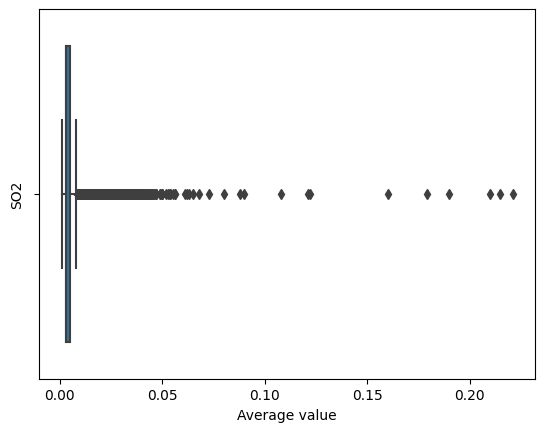

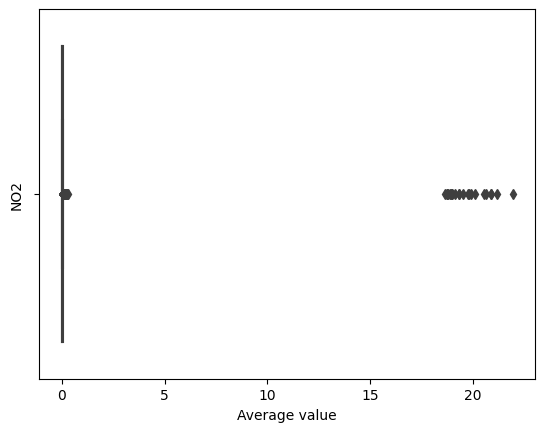

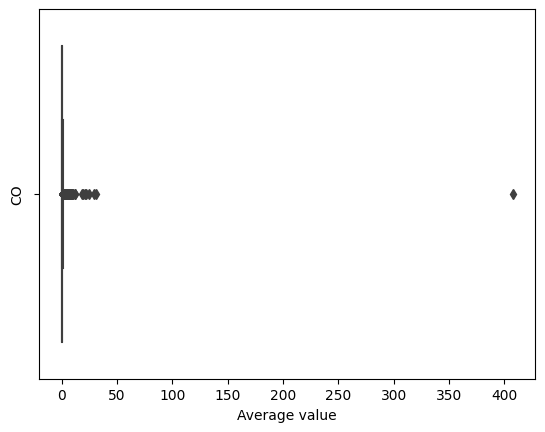

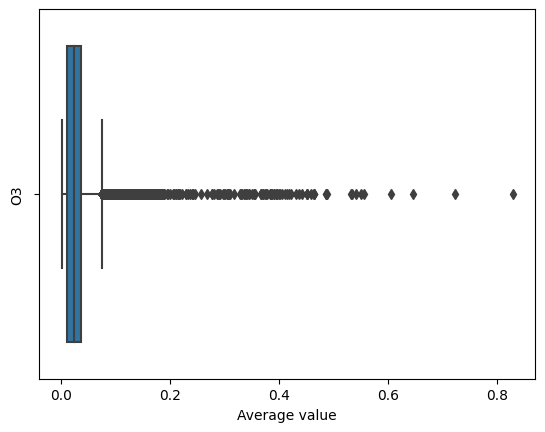

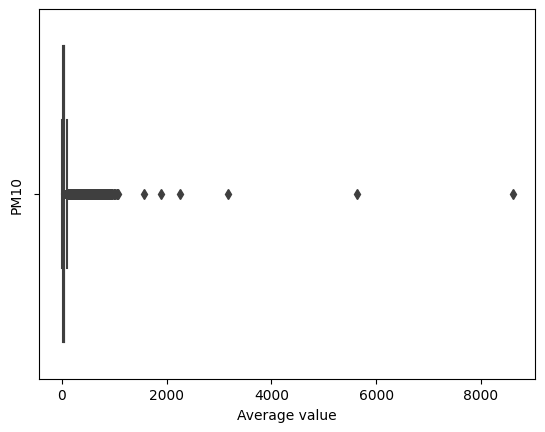

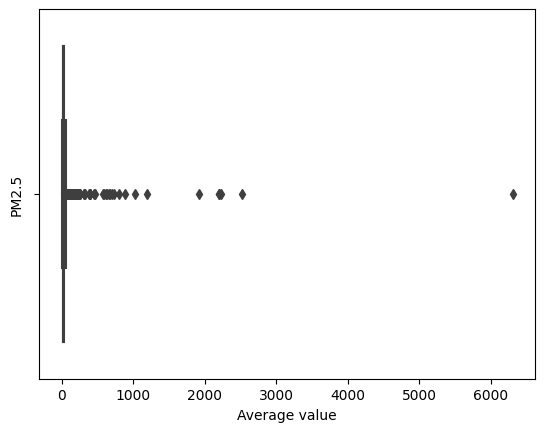

In [38]:
i = 0
for code in cat_codes['Category code']: 
    plt.figure(i)
    sns.boxplot(x = data[data['Category code'] == code]['Average value']).set(ylabel=cat_codes['Category name'][i])
    i += 1

There are two outliers that specifically bother me as the gap between them and the rest of the data is so big - the max values of CO and PM2.5. I will remove them as I assume they must be measurement errors.

In [39]:
data = data.drop(data[(data['Category code'] == 5) & (data['Average value'] > 300)].index)
data = data.drop(data[(data['Category code'] == 9) & (data['Average value'] > 5000)].index)

Other than that, I will not be removing any other outliers as the values seem realistic thanks to the large standard deviation and large intervals of expected values.

### What are the characteristics of your dataset? Do you see any trends in the data? (5%)

Before starting the analysis, I suspected there would be daily and seasonal trends. Daily, I suspected pollution would spike during commute time as many use cars to go to and from work, and buses go more frequently at that time. Seasonally, I suspected winter might see some spikes as people would be more likely to commute by car than walk or take public transport due to the cold. Dust storms in the spring are also said to bring yellow dust from China and other parts of Asia, so I assumed spring months, during which the dust storms happen, would also see elevated levels of pollution. I also suspected that some parts of the city would, on average, be more badly polluted than others. I assumed that districts with high traffic concentration, especially in the city centre, would suffer from more pollution. 

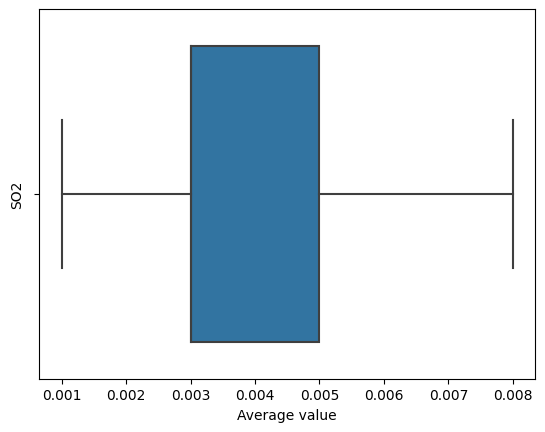

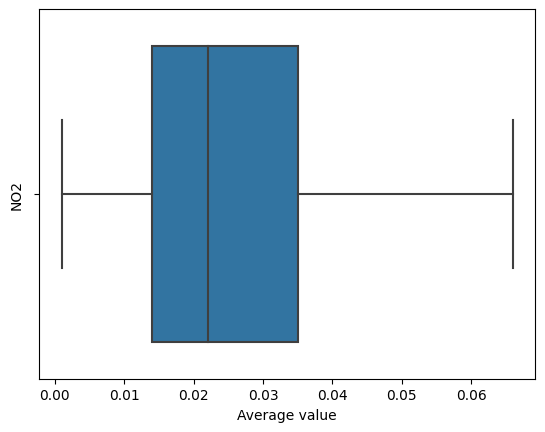

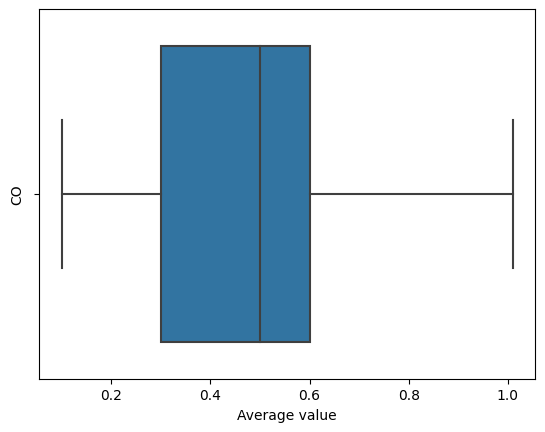

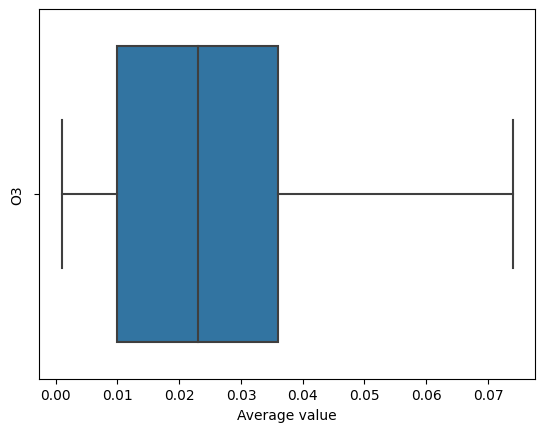

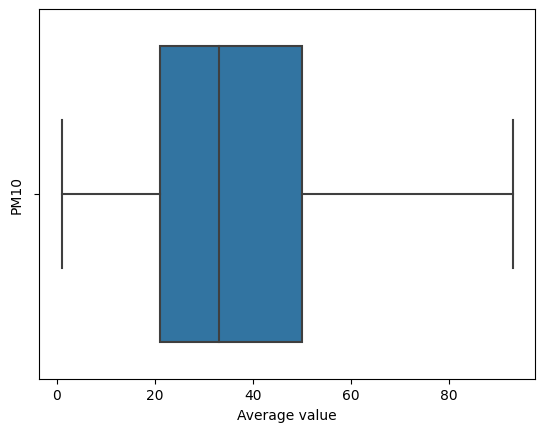

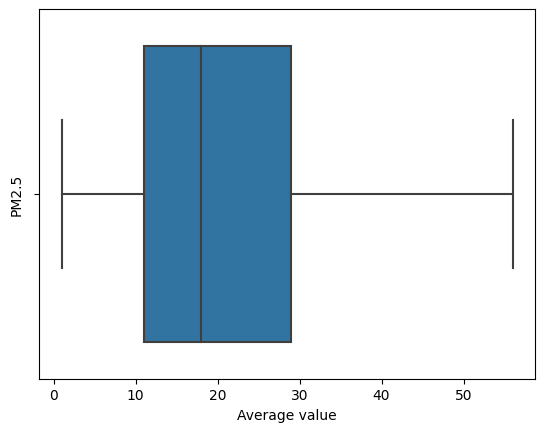

In [40]:
i = 0
for code in cat_codes['Category code']: 
    plt.figure(i)
    sns.boxplot(x = data[data['Category code'] == code]['Average value'], 
                showfliers=False).set(ylabel=cat_codes['Category name'][i])
    i += 1

It seems that for the middle quartiles, we have a standard Gaussian distribution of the data. Despite seeing before that there are some potential outliers on the right, many of these distributions are leaning slightly to the left, suggesting that the air quality tends to be on the better side of the spectrum. It is necessary to note though that does not necessarily mean the city is not polluted, only that it has more good days than bad ones, and the bad days are significantly worse than the good days.

I will now make some new dataframes to check for seasonal and daily trends so that I can see whether there is a trend worth exploring later on. If there is a trend, it might be worth it to explore and exploit it further as a part of the ML model in the following sections.

In [41]:
# I will make a copy of the data for this manipulation in case I accidentally mess something up

data2 = data.copy()

In [42]:
data2

,Date,Hour,Measurement station code,Category code,Average value
0,20170101,1,101,1,0.004
1,20170101,1,101,3,0.059
2,20170101,1,101,5,1.200
3,20170101,1,101,6,0.002
4,20170101,1,101,8,73.000
...,...,...,...,...,...
9874255,20211231,24,184,3,0.016
9874256,20211231,24,184,5,0.600
9874257,20211231,24,184,6,0.031
9874258,20211231,24,184,8,25.000


In [43]:
cat_codes

,Category code,Category name,Unit,Good,Normal,Bad,Very bad
0,1,SO2,ppm,0.02,0.05,0.15,1.0
1,3,NO2,ppm,0.03,0.06,0.20,2.0
2,5,CO,ppm,2.00,9.00,15.00,50.0
3,6,O3,ppm,0.03,0.09,0.15,0.5
4,8,PM10,μg/m^3,30.00,80.00,150.00,600.0
5,9,PM2.5,μg/m^3,15.00,35.00,75.00,500.0


In [44]:
cat1 = data2[data2['Category code'] == 1]
cat2 = data2[data2['Category code'] == 3]
cat3 = data2[data2['Category code'] == 5]
cat4 = data2[data2['Category code'] == 6]
cat5 = data2[data2['Category code'] == 8]
cat6 = data2[data2['Category code'] == 9]

Let's take the arithmetic average of the locations for that since we do not care about the exact location for this model. It is a potential extention for this project for the future but I will consider Seoul as a whole throughout this notebook.

In [45]:
cat1 = cat1.groupby(['Date', 'Hour'], as_index=False)['Average value'].mean().rename(columns={'Average value': 'SO2'})
cat2 = cat2.groupby(['Date', 'Hour'], as_index=False)['Average value'].mean().rename(columns={'Average value': 'NO2'})
cat3 = cat3.groupby(['Date', 'Hour'], as_index=False)['Average value'].mean().rename(columns={'Average value': 'CO'})
cat4 = cat4.groupby(['Date', 'Hour'], as_index=False)['Average value'].mean().rename(columns={'Average value': 'O3'})
cat5 = cat5.groupby(['Date', 'Hour'], as_index=False)['Average value'].mean().rename(columns={'Average value': 'PM10'})
cat6 = cat6.groupby(['Date', 'Hour'], as_index=False)['Average value'].mean().rename(columns={'Average value': 'PM2.5'})

In [46]:
data_hours = pd.merge(cat1, cat2, on=['Date', 'Hour'])
data_hours = pd.merge(data_hours, cat3, on=['Date', 'Hour'])
data_hours = pd.merge(data_hours, cat4, on=['Date', 'Hour'])
data_hours = pd.merge(data_hours, cat5, on=['Date', 'Hour'])
data_hours = pd.merge(data_hours, cat6, on=['Date', 'Hour'])

In [47]:
data_hours

,Date,Hour,SO2,NO2,CO,O3,PM10,PM2.5
0,20170101,1,0.005394,0.049784,1.350000,0.004528,76.833333,53.285714
1,20170101,2,0.005121,0.047514,1.322222,0.004833,74.694444,54.944444
2,20170101,3,0.004939,0.045730,1.277778,0.004500,72.675676,52.540541
3,20170101,4,0.004727,0.042595,1.255556,0.005333,71.918919,50.297297
4,20170101,5,0.004636,0.039757,1.282857,0.005111,68.135135,48.594595
...,...,...,...,...,...,...,...,...
43819,20211231,20,0.003000,0.019842,0.397297,0.025684,23.000000,5.810811
43820,20211231,21,0.003000,0.016658,0.400000,0.028105,22.263158,7.184211
43821,20211231,22,0.003000,0.015868,0.416216,0.027684,19.729730,7.081081
43822,20211231,23,0.003053,0.016816,0.432432,0.026421,20.842105,8.526316


Now we can easily check the daily and hourly trend of the data accross all the pollutants.

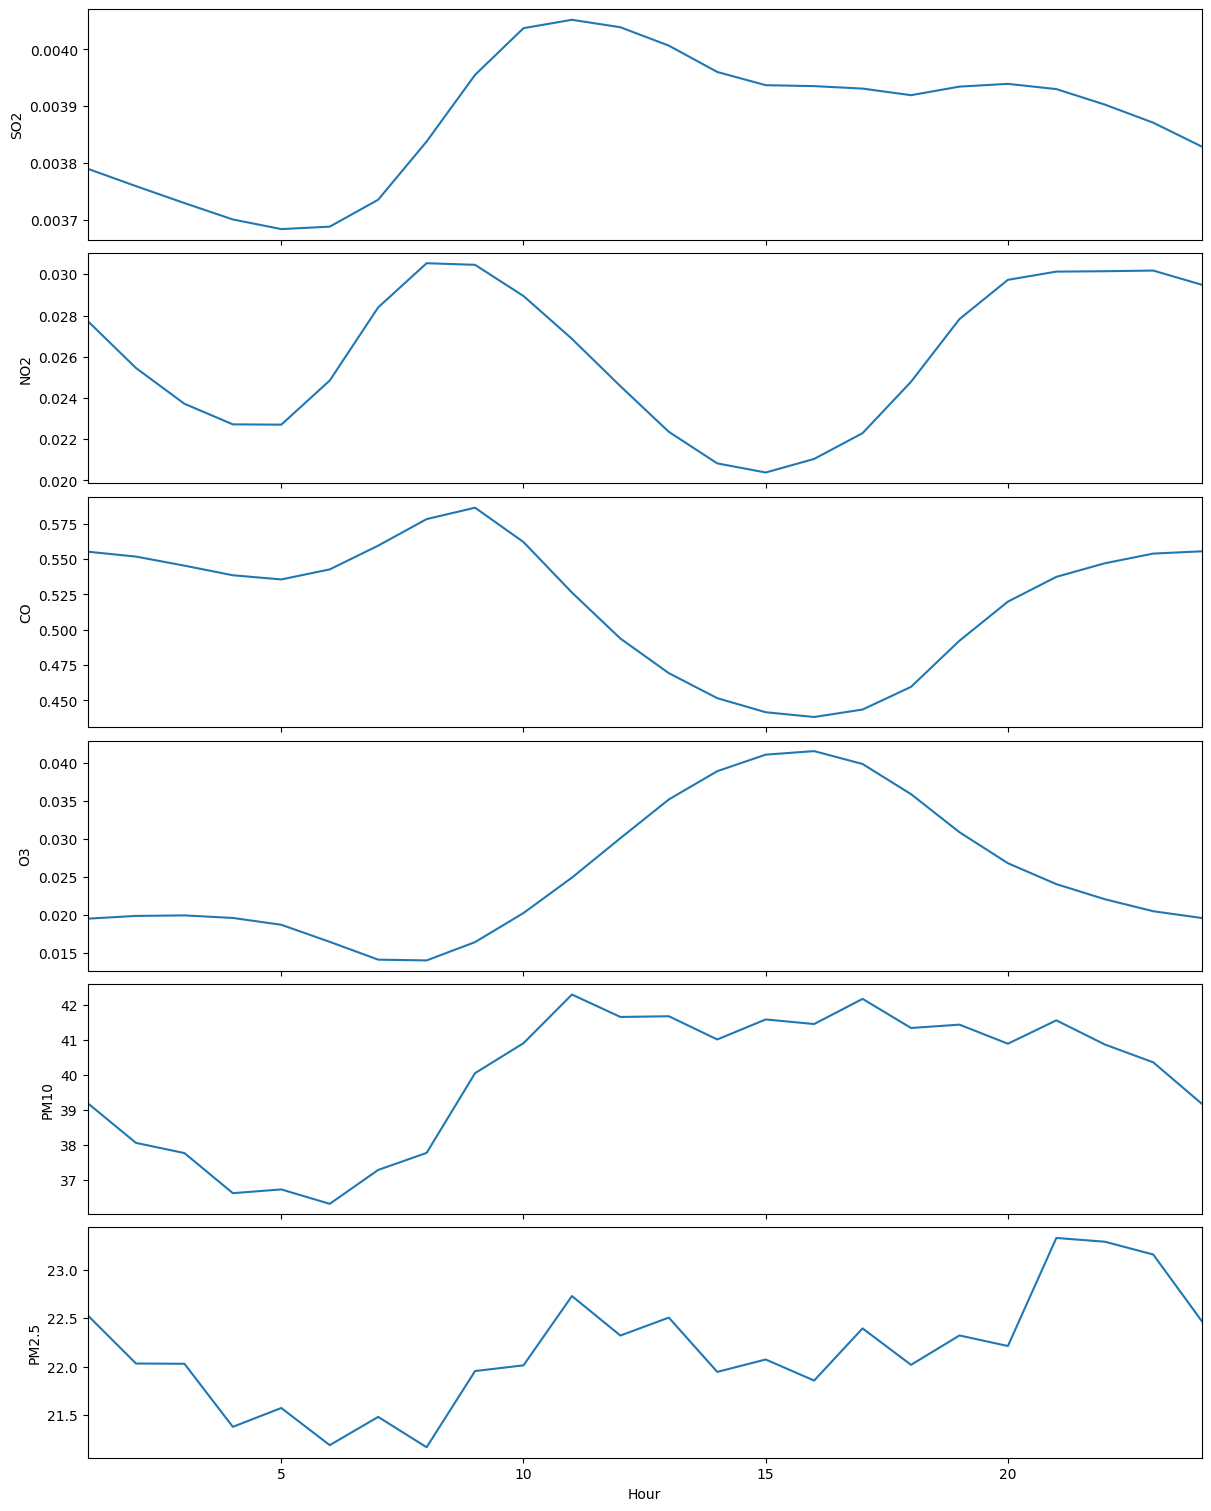

In [48]:
fig, ax = plt.subplots(6, 1, figsize=(12, 15), sharex=True, constrained_layout=True)

temp = data_hours.groupby(['Hour'], as_index=False)['SO2'].mean()
sns.lineplot(x=temp['Hour'], y=temp['SO2'], ax=ax[0])

temp = data_hours.groupby(['Hour'], as_index=False)['NO2'].mean()
sns.lineplot(x=temp['Hour'], y=temp['NO2'], ax=ax[1])

temp = data_hours.groupby(['Hour'], as_index=False)['CO'].mean()
sns.lineplot(x=temp['Hour'], y=temp['CO'], ax=ax[2])

temp = data_hours.groupby(['Hour'], as_index=False)['O3'].mean()
sns.lineplot(x=temp['Hour'], y=temp['O3'], ax=ax[3])

temp = data_hours.groupby(['Hour'], as_index=False)['PM10'].mean()
sns.lineplot(x=temp['Hour'], y=temp['PM10'], ax=ax[4])

temp = data_hours.groupby(['Hour'], as_index=False)['PM2.5'].mean()
sns.lineplot(x=temp['Hour'], y=temp['PM2.5'], ax=ax[5])

plt.xlim(1,24)
plt.show()

We can see there are discernable daily trends for most of the pollutants! 

1. SO2, NO2, CO seem to move together for the most part and peak in the morning and evening, which are commuting times. Since all of these are created as a result of burning fossil fuels, it makes perfect sense.
2. Since O3 is created through reaction of sunlight with other pollutants, it makes sense that it would peak during the day after the peak of the other pollutants. It could also be the fact that there is more sunlight during the afternoon which would naturally lead to more O3. We cannot be sure yet whether it is the other pollutants or simply the presence of the sun that causes O3 to spike.
3. PM10 and PM2.5 reflect the levels of particle matter in general and are the most important part of the analysis as they have the greatest adverse effect on human health. Especially high levels of PM2.5 should be avoided as those particles are more harmful than PM10. While PM10 is high throughout the day, PM2.5 peaks in the evening.

Now let's see the yearly trends.

In [49]:
days = []
for val in data_hours['Date'].values:
    days.append((val // 10 % 10)*10+(val // 1 % 10))
data_days = data_hours.copy()
data_days['Day'] = days

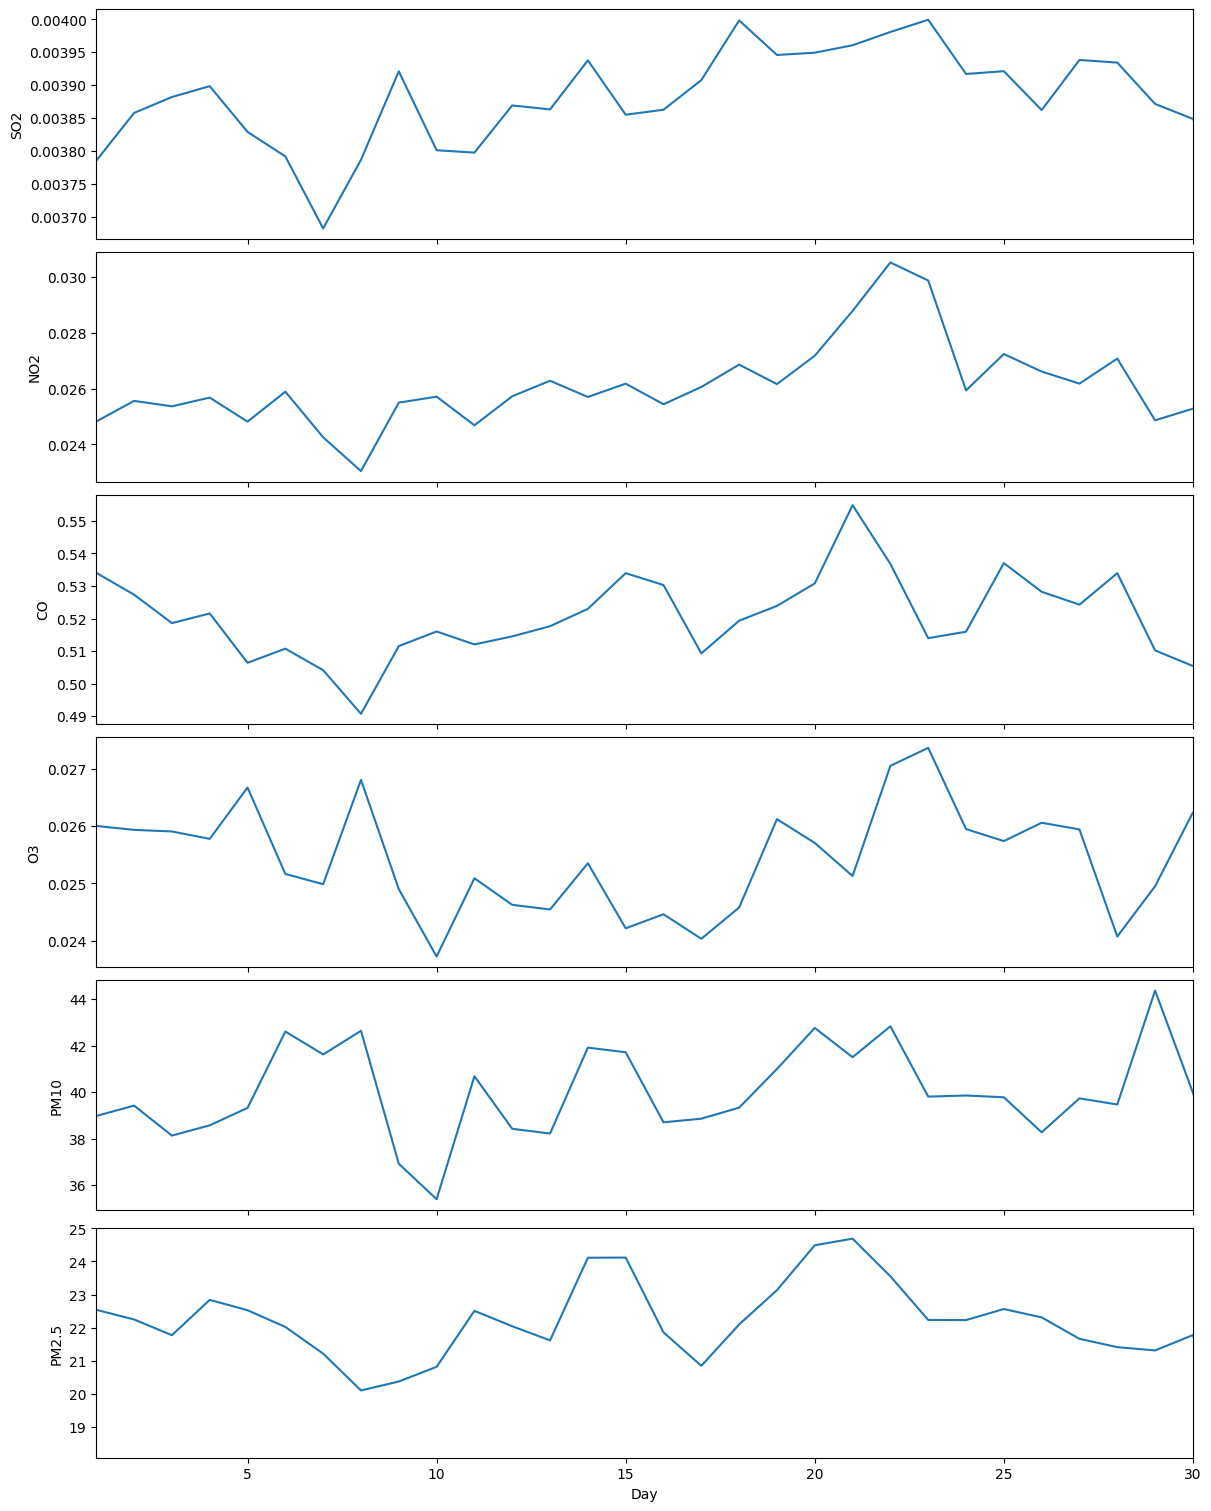

In [50]:
fig, ax = plt.subplots(6, 1, figsize=(12, 15), sharex=True, constrained_layout=True)

temp = data_days.groupby(['Day'], as_index=False)['SO2'].mean()
sns.lineplot(x=temp['Day'], y=temp['SO2'], ax=ax[0])

temp = data_days.groupby(['Day'], as_index=False)['NO2'].mean()
sns.lineplot(x=temp['Day'], y=temp['NO2'], ax=ax[1])

temp = data_days.groupby(['Day'], as_index=False)['CO'].mean()
sns.lineplot(x=temp['Day'], y=temp['CO'], ax=ax[2])

temp = data_days.groupby(['Day'], as_index=False)['O3'].mean()
sns.lineplot(x=temp['Day'], y=temp['O3'], ax=ax[3])

temp = data_days.groupby(['Day'], as_index=False)['PM10'].mean()
sns.lineplot(x=temp['Day'], y=temp['PM10'], ax=ax[4])

temp = data_days.groupby(['Day'], as_index=False)['PM2.5'].mean()
sns.lineplot(x=temp['Day'], y=temp['PM2.5'], ax=ax[5])

plt.xlim(1,30)
plt.show()

It seems that there is no strong trends accross the days of the month. That makes sense as there is little that distinguishes certain days of the month from others. We are certain to see stronger trends in timeframes that have more distinguishing factors such as the time of the day (which we have seen above) or month of the year (which we will see now).

In [51]:
months = []
for val in data_hours['Date'].values:
    months.append((val // 1000 % 10)*10+(val // 100 % 10))
data_months = data_hours.copy()
data_months['Month'] = months

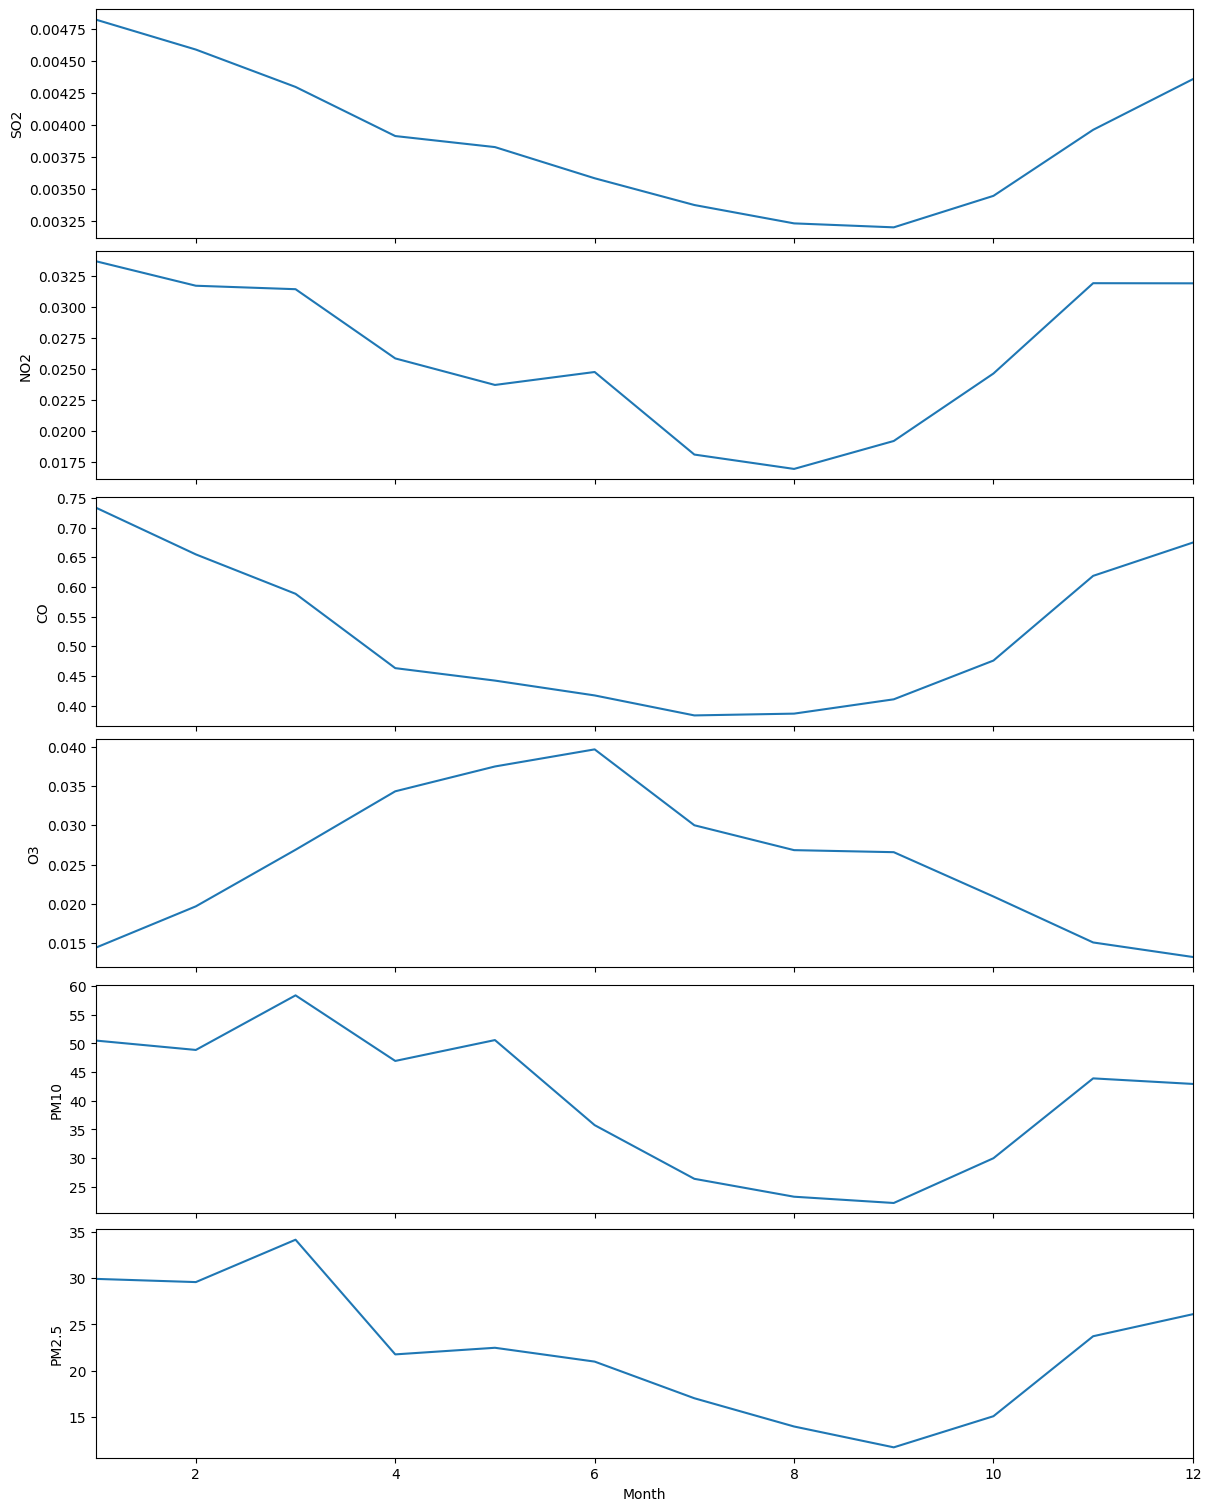

In [52]:
fig, ax = plt.subplots(6, 1, figsize=(12, 15), sharex=True, constrained_layout=True)

temp = data_months.groupby(['Month'], as_index=False)['SO2'].mean()
sns.lineplot(x=temp['Month'], y=temp['SO2'], ax=ax[0])

temp = data_months.groupby(['Month'], as_index=False)['NO2'].mean()
sns.lineplot(x=temp['Month'], y=temp['NO2'], ax=ax[1])

temp = data_months.groupby(['Month'], as_index=False)['CO'].mean()
sns.lineplot(x=temp['Month'], y=temp['CO'], ax=ax[2])

temp = data_months.groupby(['Month'], as_index=False)['O3'].mean()
sns.lineplot(x=temp['Month'], y=temp['O3'], ax=ax[3])

temp = data_months.groupby(['Month'], as_index=False)['PM10'].mean()
sns.lineplot(x=temp['Month'], y=temp['PM10'], ax=ax[4])

temp = data_months.groupby(['Month'], as_index=False)['PM2.5'].mean()
sns.lineplot(x=temp['Month'], y=temp['PM2.5'], ax=ax[5])

plt.xlim(1,12)
plt.show()

As I hypothesised, there are stong trends accross the months of the year. As usually, O3 goes against the trend of the other pollutants. 

1. At this point, it is clear that O3 is more related to the time of day and time of year than to the level of other pollutants in the atmosphere. It is created through reactions of other pollutants with sunlight and thus is higher during times when there is more sun, and its spikes coincide with the afternoons and summers when the levels and daily duration of sunlight are the highest.
2. Other pollutants seem to be highest during winter and lower during the summer. That confirms my hypothesis that in winter, pollution will be higher due to the fact that people drive more and use more heat and electricity.
3. Some pollutants (SO2 and NO2) and both PM10 and PM2.5 remain quite high during the spring months as well. That supports the hypothesis that a portion of these pollutants comes to Seoul as a result of the Asian Dust storms.

In [53]:
years = []
for val in data_hours['Date'].values:
    years.append(math.floor(val/10000))
data_years = data_hours.copy()
data_years['Year'] = years

In [54]:
data_years

,Date,Hour,SO2,NO2,CO,O3,PM10,PM2.5,Year
0,20170101,1,0.005394,0.049784,1.350000,0.004528,76.833333,53.285714,2017
1,20170101,2,0.005121,0.047514,1.322222,0.004833,74.694444,54.944444,2017
2,20170101,3,0.004939,0.045730,1.277778,0.004500,72.675676,52.540541,2017
3,20170101,4,0.004727,0.042595,1.255556,0.005333,71.918919,50.297297,2017
4,20170101,5,0.004636,0.039757,1.282857,0.005111,68.135135,48.594595,2017
...,...,...,...,...,...,...,...,...,...
43819,20211231,20,0.003000,0.019842,0.397297,0.025684,23.000000,5.810811,2021
43820,20211231,21,0.003000,0.016658,0.400000,0.028105,22.263158,7.184211,2021
43821,20211231,22,0.003000,0.015868,0.416216,0.027684,19.729730,7.081081,2021
43822,20211231,23,0.003053,0.016816,0.432432,0.026421,20.842105,8.526316,2021


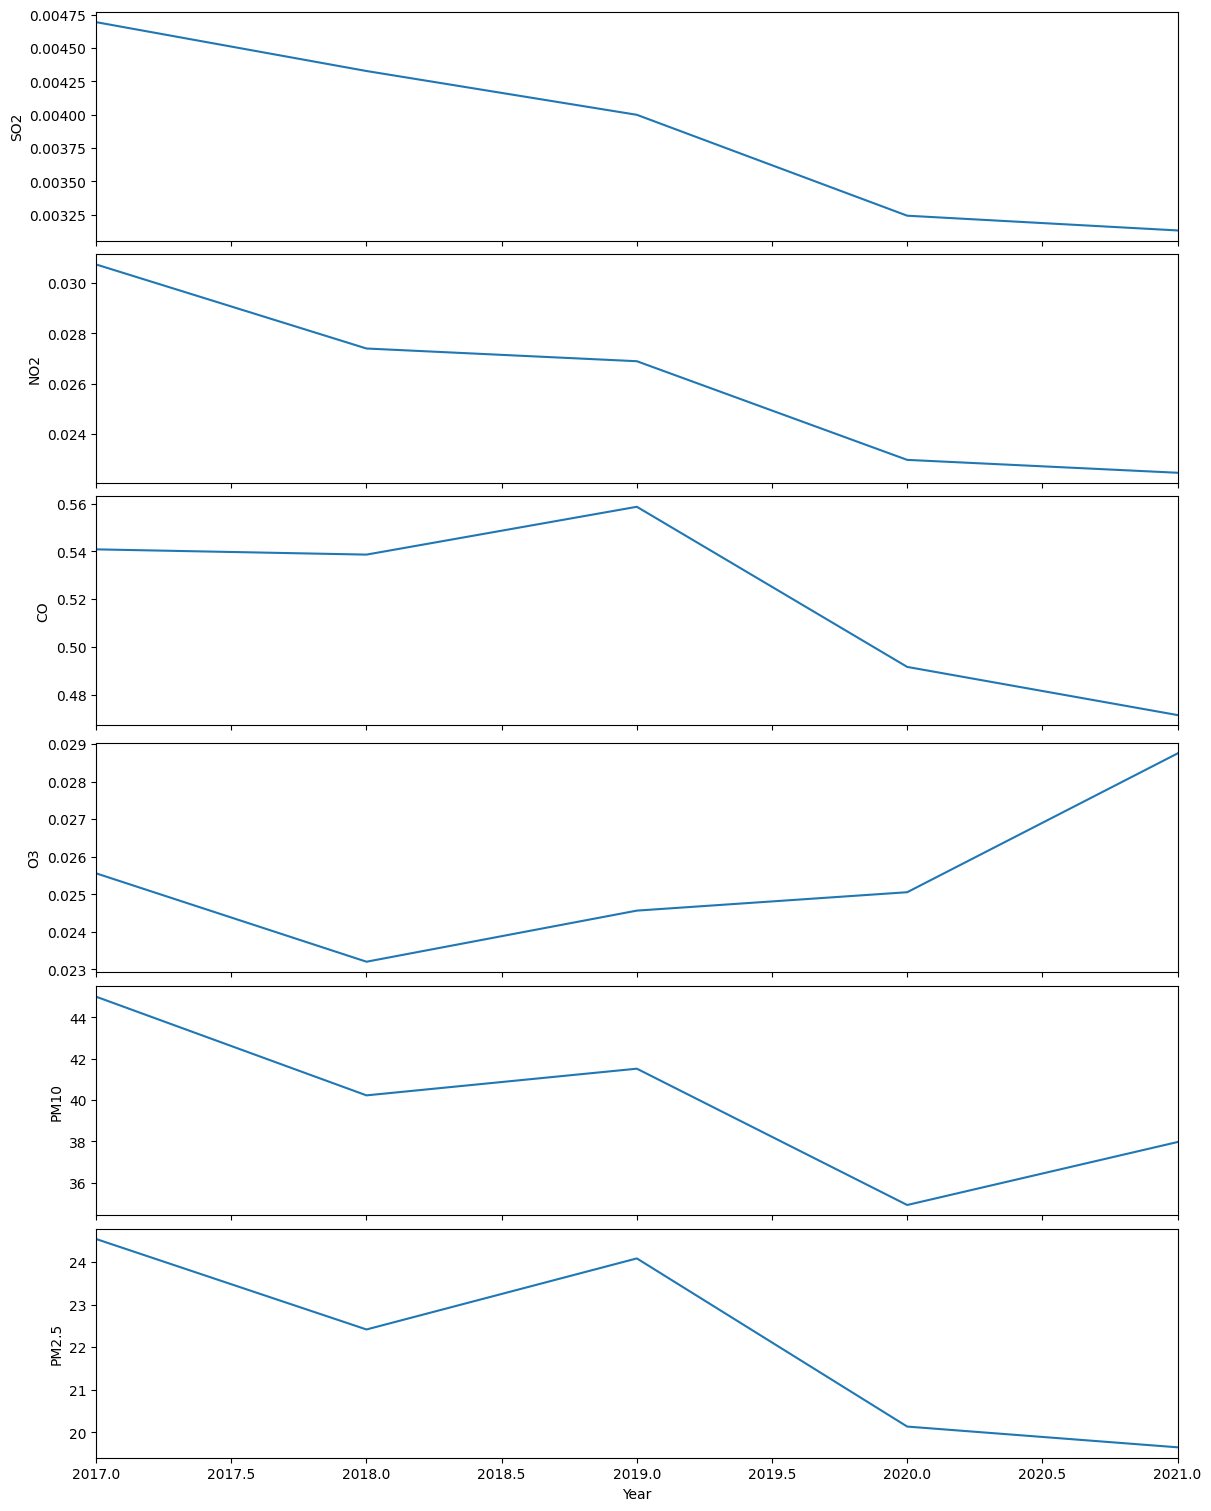

In [55]:
fig, ax = plt.subplots(6, 1, figsize=(12, 15), sharex=True, constrained_layout=True)

temp = data_years.groupby(['Year'], as_index=False)['SO2'].mean()
sns.lineplot(x=temp['Year'], y=temp['SO2'], ax=ax[0])

temp = data_years.groupby(['Year'], as_index=False)['NO2'].mean()
sns.lineplot(x=temp['Year'], y=temp['NO2'], ax=ax[1])

temp = data_years.groupby(['Year'], as_index=False)['CO'].mean()
sns.lineplot(x=temp['Year'], y=temp['CO'], ax=ax[2])

temp = data_years.groupby(['Year'], as_index=False)['O3'].mean()
sns.lineplot(x=temp['Year'], y=temp['O3'], ax=ax[3])

temp = data_years.groupby(['Year'], as_index=False)['PM10'].mean()
sns.lineplot(x=temp['Year'], y=temp['PM10'], ax=ax[4])

temp = data_years.groupby(['Year'], as_index=False)['PM2.5'].mean()
sns.lineplot(x=temp['Year'], y=temp['PM2.5'], ax=ax[5])

plt.xlim(2017,2021)
plt.show()

We can see there are some trends across the years as well (although those should be taken with a grain of salt as there are only 5 years, making the number of samples small).

1. Interestingly, the value of O3 rises as the other values fall during 2020 and 2021. Same for PM10 in 2021.
2. All the main pollutants (SO2, NO2 and CO) along with the most harmful particle indicator (PM2.5) fell during 2020 and 2021. We can assume that is the effect of COVID that halted a lot of travel and production.

# Task and evaluation (10%)

A task with the greatest impact this dataset could be used for is predicting the concentrations of pollutants in the air in order to drive policy decisions and individual behaviours. A particularly immediate impact could be felt on the individual level. It is not difficult to adjust individual behavious to new information and reduction of exposure to pollution could have a significant positive impact of life quality. Pollution can decrease cognitive skills (https://www.pnas.org/doi/10.1073/pnas.1809474115), life expectancy and other health outcomes (https://www.sciencedirect.com/science/article/pii/S2542519618302614). Especially for individuals with preexisting conditions such as asthma, being able to predict pollution concentrations could greatly improve their quality of life. Therefore, simply providing accurate predictions of pollution to individuals could improve SDG3 and SDG4. 

Since individual health is our main concern for this model, the main data series of the greatest interest is the PM2.5 column. For the model, it is necessary to choose data wisely, and without expert knowledge on air pollution and chemistry, the safest option is to choose a single variable of interest. SO2, NO2 and CO all contribute to the creation of O3, and all of the above contribute to creation of PM2.5. Aditionally, all PM2.5 particles are also PM10 particles as the number is simply classification of size. As such, there is a lot of dependency among the variables which is impossible to isolate without expert knowledge, so I will only be creating an ML model to predict PM2.5.

I hypothesise that levels of pollution can be predicted simply from previous levels of pollution, taking into account the time of year and day. That information can be relayed to individuals to inform them whether it will be safe for them to move outside in the polluted air at a given time. For this task, the best technique would be a time-series forecast with classification.

In terms of the actual model, for time-series data, it is common to start with a linear model for trend recognition. It is important to note here that I am working only with the past 5 years of data, and the last 2 years of that are quite abnormal due to Covid. Therefore, rather than linear regression, I will use a polynomial, as it will fit the data more accuratelly.

# Design and build an ML system (20%)

First, I will work on trend prediction. For that, I want to simplify the dataframe to only contain the time data and PM2.5 data. I will build 3 different models and evaluate their performance.

1. Firstly, I will identify a yearly trend with a linear regression with polynomial features. While the trendline fits the data quite accurately, it is only a proof that the data is predictable in general; as we want the prediction to be useful for individual's who want to limit their exposure to pollution during the day, monthly trends are not very useful.
2. I will build on the basic model with XGBoost to improve the yearly trend prediction and further support my point that the data is suitable for ML tasks.
3. I will use a multistep model to forecast hourly pollution with different models: simple linear regression, multi-output with MultiOutputRegressor, and recursion with RegressorChain

In [56]:
data_ml = data_hours[['Date', 'Hour', 'PM2.5']]

In [57]:
data_ml['Date and time'] = data_ml['Date'].map(str) + data_ml['Hour'].map(str)

C:\Users\Adriana\AppData\Local\Temp\ipykernel_16684\3349049990.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml['Date and time'] = data_ml['Date'].map(str) + data_ml['Hour'].map(str)


In [58]:
data_ml['Date']

0        20170101
1        20170101
2        20170101
3        20170101
4        20170101
           ...   
43819    20211231
43820    20211231
43821    20211231
43822    20211231
43823    20211231
Name: Date, Length: 43824, dtype: int32

In [59]:
dates = []
for n in data_ml['Date'].values:
    last_4_digits = n % 10000
    dates.append(1900 * 10000 + last_4_digits)
data_ml['Mod date'] = dates

C:\Users\Adriana\AppData\Local\Temp\ipykernel_16684\2012251771.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml['Mod date'] = dates


In [60]:
# dropping all the days that are higher than 28th, as that is how long the shortest month is, in order to
# avoid issues later when we convert this into a timestamp with no regard for years

data_ml_filter = data_ml[(10*((data_ml['Mod date'] // 10) % 10) + ((data_ml['Mod date'] // 1) % 10)) <= 28]

In [61]:
data_ml_filter

,Date,Hour,PM2.5,Date and time,Mod date
0,20170101,1,53.285714,201701011,19000101
1,20170101,2,54.944444,201701012,19000101
2,20170101,3,52.540541,201701013,19000101
3,20170101,4,50.297297,201701014,19000101
4,20170101,5,48.594595,201701015,19000101
...,...,...,...,...,...
43747,20211228,20,39.342105,2021122820,19001228
43748,20211228,21,40.605263,2021122821,19001228
43749,20211228,22,40.710526,2021122822,19001228
43750,20211228,23,42.026316,2021122823,19001228


In [62]:
data_ml_filter['Mod date'] = pd.to_datetime(data_ml_filter['Mod date'], format='%Y%m%d', errors='coerce')

C:\Users\Adriana\AppData\Local\Temp\ipykernel_16684\2266312102.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml_filter['Mod date'] = pd.to_datetime(data_ml_filter['Mod date'], format='%Y%m%d', errors='coerce')


In [63]:
y = data_ml_filter.copy().set_index('Mod date').drop(columns=['Hour', 'Date and time', 'Date'])

In [64]:
y

,PM2.5
Mod date,
1900-01-01,53.285714
1900-01-01,54.944444
1900-01-01,52.540541
1900-01-01,50.297297
1900-01-01,48.594595
...,...
1900-12-28,39.342105
1900-12-28,40.605263
1900-12-28,40.710526


I will follow the tutorial that the Professor provided for time series. I will add some comments throughout to demonstrate understanding, and indicate any changes I have made.

In [65]:
# I have discared years from the consideration (changed all the years arbitrarily to 1900), grouped and averaged all
# by the day and the month, and made in into a new dataframe for the model

y = y.groupby(['Mod date'], as_index=True).mean()

In [66]:
# Using DeterministicProcess to make deterministic terms, i.e. terms that are completely determined
# by their past values. Thanks to this nature of deterministic terms, they are useful for time series,
# which is what we're dealing with here. Compared to the tutorial, I have increased the order to 3 as we are
# dealing with data with a more complex trend (not simply upward but going up and down throughout the year).
# I have also added the period to be 28 as we are dealing with modified month periods in which each month has 
# 28 days.

dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=3,
    period=28,
    drop=True
)

In [67]:
X = dp.in_sample()

In [68]:
# I chose the test size to be 0.1. I know most test sets are a larger percentage but I do not want to be my
# test set to be the entirety of the winter season as that would make the model to ignore the increasing trend
# that we have previously discovered.

idx_train, idx_test = train_test_split(
    y.index, test_size=0.1, shuffle=False,
)
X_train, X_test = X.loc[idx_train, :], X.loc[idx_test, :]
y_train, y_test = y.loc[idx_train], y.loc[idx_test]

In [69]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [70]:
# Now I simply fit the model and predict

y_fit = pd.DataFrame(
    model.predict(X_train),
    index=y_train.index,
    columns=y_train.columns,
)
y_pred = pd.DataFrame(
    model.predict(X_test),
    index=y_test.index,
    columns=y_test.columns,
)

C:\Users\Adriana\AppData\Local\Temp\ipykernel_16684\378171244.py:10: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
C:\Users\Adriana\AppData\Local\Temp\ipykernel_16684\378171244.py:11: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
C:\Users\Adriana\AppData\Local\Temp\ipykernel_16684\378171244.py:12: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)


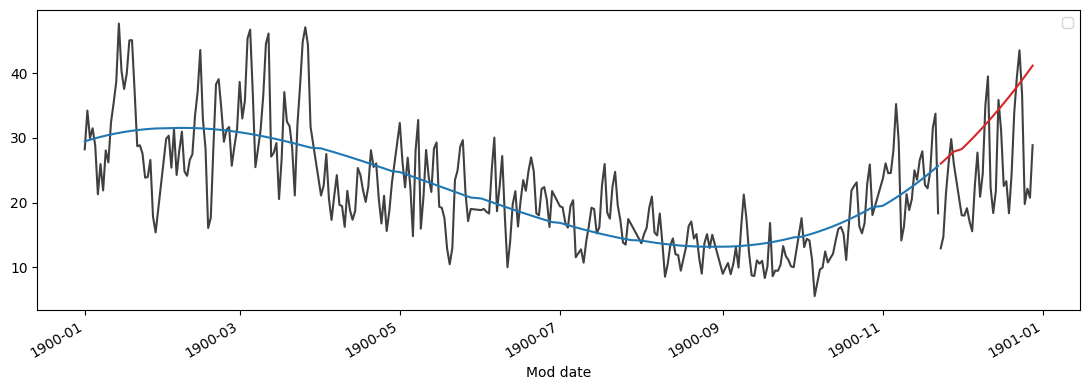

In [71]:
plt.rc(
    "figure",
    autolayout=True,
    figsize=(11, 4),
    titlesize=18,
    titleweight='bold',
)

axs = y_train.plot(color='0.25', subplots=True, sharex=True)
axs = y_test.plot(color='0.25', subplots=True, sharex=True, ax=axs)
axs = y_fit.plot(color='C0', subplots=True, sharex=True, ax=axs)
axs = y_pred.plot(color='C3', subplots=True, sharex=True, ax=axs)
for ax in axs: ax.legend([])

We can see that an ML model was able to represent the trend of increasing pollution in the winter. As stated above, that is not necessarily useful on its own for the specific application I am going for, but demonstrates that the data can be predicted with some accuracy. That being said, we can see that the fit of the trendline could be improved. To do that, let's make residuals and feed them back into the model.

In [72]:
y_fit = pd.DataFrame(data=y_fit.values).set_index(y_fit.index).rename(columns={0: 'PM2.5'})
y_pred = pd.DataFrame(data=y_pred.values).set_index(y_pred.index).rename(columns={0: 'PM2.5'})

In [73]:
y_fit

,PM2.5
Mod date,
1900-01-01,29.467156
1900-01-02,29.592553
1900-01-03,29.713703
1900-01-04,29.830639
1900-01-05,29.943395
...,...
1900-11-18,24.311277
1900-11-19,24.642639
1900-11-20,24.979668


In [74]:
y_train

,PM2.5
Mod date,
1900-01-01,28.233488
1900-01-02,34.222861
1900-01-03,29.967762
1900-01-04,31.489254
1900-01-05,28.768437
...,...
1900-11-18,22.203744
1900-11-19,24.735792
1900-11-20,31.543593


In [75]:
y_train

,PM2.5
Mod date,
1900-01-01,28.233488
1900-01-02,34.222861
1900-01-03,29.967762
1900-01-04,31.489254
1900-01-05,28.768437
...,...
1900-11-18,22.203744
1900-11-19,24.735792
1900-11-20,31.543593


In [76]:
# Creating a residual to improve the model - the difference between the observed value and the predicted value
y_resid = y_train - y_fit

# Pivoting and squeezing data to fit into the XGBoost
y_fit = y_fit.stack().squeeze()
y_pred = y_pred.stack().squeeze()

xgb = XGBRegressor()
xgb.fit(X_train, y_resid)

# Building on the previous model and improving it by including the XGBoosted residuals
y_fit_boosted = xgb.predict(X_train) + y_fit
y_pred_boosted = xgb.predict(X_test) + y_pred

In [77]:
y_train

,PM2.5
Mod date,
1900-01-01,28.233488
1900-01-02,34.222861
1900-01-03,29.967762
1900-01-04,31.489254
1900-01-05,28.768437
...,...
1900-11-18,22.203744
1900-11-19,24.735792
1900-11-20,31.543593


C:\Users\Adriana\AppData\Local\Temp\ipykernel_16684\1258794725.py:4: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_test.plot(
C:\Users\Adriana\AppData\Local\Temp\ipykernel_16684\1258794725.py:7: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_fit_boosted.unstack([None]).plot(
C:\Users\Adriana\AppData\Local\Temp\ipykernel_16684\1258794725.py:10: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  axs = y_pred_boosted.unstack([None]).plot(


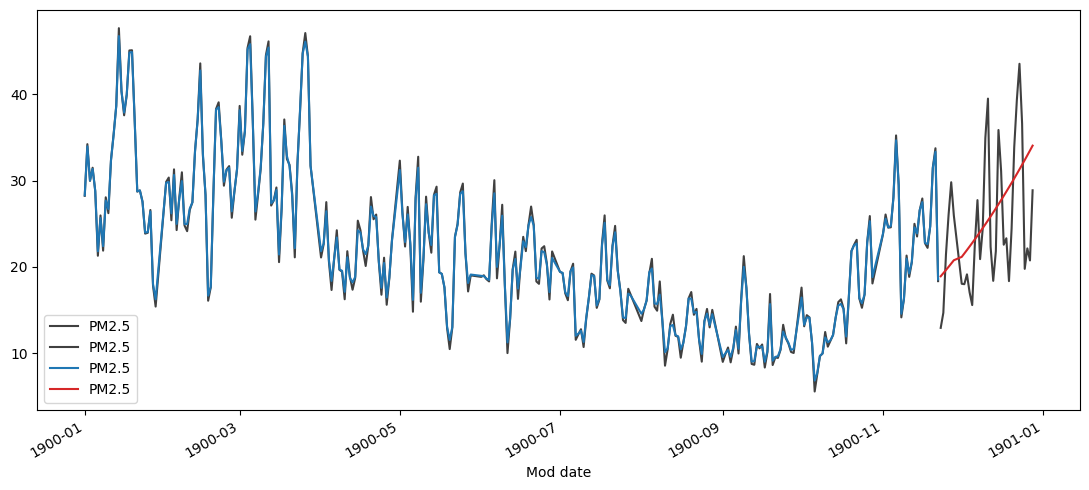

In [78]:
axs = y_train.plot(
    color='0.25', figsize=(11, 5), subplots=True, sharex=True,
)
axs = y_test.plot(
    color='0.25', subplots=True, sharex=True, ax=axs,
)
axs = y_fit_boosted.unstack([None]).plot(
    color='C0', subplots=True, sharex=True, ax=axs,
)
axs = y_pred_boosted.unstack([None]).plot(
    color='C3', subplots=True, sharex=True, ax=axs,
)

We can see that the prediction adjusted with the residuals was more accurate. It suggests that there is something in the data that a simple linear model could not learn but is representable by more complex models.

Now I will move on to some more informative models. I will move away from only considering the months and instead take advantage of the hourly data to predict hourly levels of PM2.5. Ultimately, as I want the prediction to be useful for people who want to adjust their behaviour accordingly to the predicted pollution levels, precise hourly predictions are the most useful.

In [79]:
data_ml_filter

,Date,Hour,PM2.5,Date and time,Mod date
0,20170101,1,53.285714,201701011,1900-01-01
1,20170101,2,54.944444,201701012,1900-01-01
2,20170101,3,52.540541,201701013,1900-01-01
3,20170101,4,50.297297,201701014,1900-01-01
4,20170101,5,48.594595,201701015,1900-01-01
...,...,...,...,...,...
43747,20211228,20,39.342105,2021122820,1900-12-28
43748,20211228,21,40.605263,2021122821,1900-12-28
43749,20211228,22,40.710526,2021122822,1900-12-28
43750,20211228,23,42.026316,2021122823,1900-12-28


In [80]:
data_ml_filter['Mod date'] = pd.to_datetime(data_ml_filter['Hour'], format='%H', errors='coerce')

C:\Users\Adriana\AppData\Local\Temp\ipykernel_16684\35502252.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_ml_filter['Mod date'] = pd.to_datetime(data_ml_filter['Hour'], format='%H', errors='coerce')


In [81]:
data_ml

,Date,Hour,PM2.5,Date and time,Mod date
0,20170101,1,53.285714,201701011,19000101
1,20170101,2,54.944444,201701012,19000101
2,20170101,3,52.540541,201701013,19000101
3,20170101,4,50.297297,201701014,19000101
4,20170101,5,48.594595,201701015,19000101
...,...,...,...,...,...
43819,20211231,20,5.810811,2021123120,19001231
43820,20211231,21,7.184211,2021123121,19001231
43821,20211231,22,7.081081,2021123122,19001231
43822,20211231,23,8.526316,2021123123,19001231


In [82]:
y = data_ml.copy().set_index('Date and time').drop(columns=['Mod date', 'Date', 'Hour'])

In [83]:
y_data = data_ml.copy().set_index('Date and time').drop(columns=['Mod date', 'Date', 'Hour'])

In [84]:
y

,PM2.5
Date and time,
201701011,53.285714
201701012,54.944444
201701013,52.540541
201701014,50.297297
201701015,48.594595
...,...
2021123120,5.810811
2021123121,7.184211
2021123122,7.081081


In [85]:
# The make_lags and make_multistep_targets functions are taken from the time series tutorial that the Professor gave us 

def make_lags(ts, lags, lead_time=1):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(lead_time, lags + lead_time)
        },
        axis=1)


# 24-hour lag
y = y['PM2.5']
X = make_lags(y, lags=24).fillna(0.0)


In [86]:
def make_multistep_target(ts, steps):
    return pd.concat(
        {f'y_step_{i + 1}': ts.shift(-i)
         for i in range(steps)},
        axis=1)


# 3-hour forecast
y = make_multistep_target(y, steps=3).dropna()

In [87]:
y, X = y.align(X, join='inner', axis=0)

In [88]:
y

,y_step_1,y_step_2,y_step_3
Date and time,,,
201701011,53.285714,54.944444,52.540541
201701012,54.944444,52.540541,50.297297
201701013,52.540541,50.297297,48.594595
201701014,50.297297,48.594595,47.416667
201701015,48.594595,47.416667,47.675676
...,...,...,...
2021123118,5.166667,5.777778,5.810811
2021123119,5.777778,5.810811,7.184211
2021123120,5.810811,7.184211,7.081081


In [89]:
# Converting the date and time information in the data into periods to be able to represent 
# them in a time series model

y.index = [x-1 if x%10!=0 else x+9-10 for x in pd.to_numeric(y.index)]
X.index = [x-1 if x%10!=0 else x+9-10 for x in pd.to_numeric(X.index)]

In [90]:
y.index = pd.to_datetime(y.index, format='%Y%m%d%H').to_period('H')

In [91]:
X.index = pd.to_datetime(X.index, format='%Y%m%d%H').to_period('H')

In [92]:
# Making the model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

In [93]:
# All plotting functions also taken from the afformentioned tutorial

def plot_multistep(y, every=1, ax=None, palette_kwargs=None):
    palette_kwargs_ = dict(palette='husl', n_colors=16, desat=None)
    if palette_kwargs is not None:
        palette_kwargs_.update(palette_kwargs)
    palette = sns.color_palette(**palette_kwargs_)
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_prop_cycle(plt.cycler('color', palette))
    for date, preds in y[::every].iterrows():
        preds.index = pd.period_range(start=date, periods=len(preds))
        preds.plot(ax=ax)
    return ax

In [94]:
# I had some issues with the formats of the date and time so there is a lot of 
# manipulations related to it. 

y_data.index = [x-1 if x%10!=0 else x+9-10 for x in pd.to_numeric(y_data.index)]

In [95]:
y_data.index = pd.to_datetime(y_data.index, format='%Y%m%d%H')

In [96]:
y_data.index = y_data.index.to_period('H')

Amount of lag features had significant impact on PC-performance/time, especially for XGBRegressor. However, it only mildly improved the performance, and mainly on train set. Chaning the forecast length had a much larger model performance implications - it seemed to scale almost linearly, with doubling the forecast period doubling the error. Setting the forecast length to 3 hours seems to be a good spot for decent performance while maintaining meaningful results.

Train RMSE: 4.30
Test RMSE: 4.35


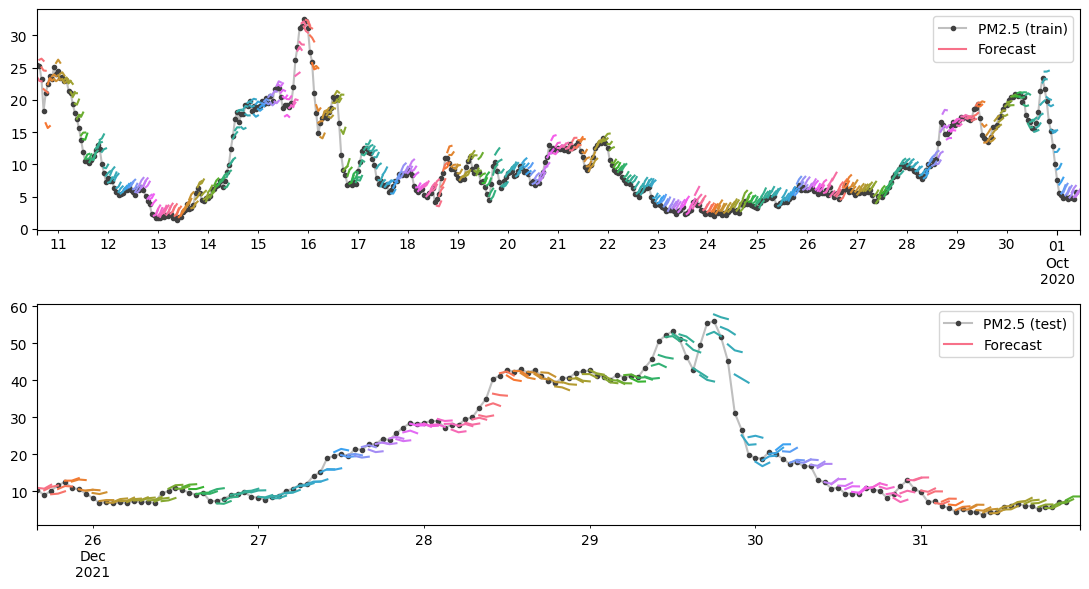

In [97]:
# Because of how long the plotting took, I only plotted a portion of each train and test sets.
# I hope that is not a problem since the task description on Moodle stated we will not be
# penalised if we shrink large datasets. Additionally, when I tried using a larger subset of the data
# to visualise, the graphs stopped making sense as they were not detailed enought to 
# be meaningful.

train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = y_data['PM2.5'][y_fit.index[-500:]].plot(
    color="0.75", style=".-", markeredgecolor="0.25",
    markerfacecolor="0.25", ax=ax1)
ax1 = plot_multistep(y_fit[-500:], ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['PM2.5 (train)', 'Forecast'])
ax2 = y_data['PM2.5'][y_pred.index[-150:]].plot(color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25", ax=ax2)
ax2 = plot_multistep(y_pred[-150:], ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['PM2.5 (test)', 'Forecast'])

We can see that the model was fairly accurately able to predit the values of PM2.5. The mean squared error for both the train and test datasets was around 4.3, which is not bad for values that range between approximately 1 and 166. 

Through trying different versions of the model I found that the root mean squared error increased approximately linearly with the number of hours I was forecasting. It is necessary to consider the tradeoff when making the final decisions for the forecast length - I chose to forecast 3 hours as it offered very small error and seems to be a decent window of time for people to plan their movement outside around - but other periods, such as 8 or 12 hours, would also make sense and might be more useful for some people.

The train and test error are also very close to each other, suggesting that the model is generalisable and did not overfit on training data.

In [98]:
model = MultiOutputRegressor(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 2.76
Test RMSE: 4.87


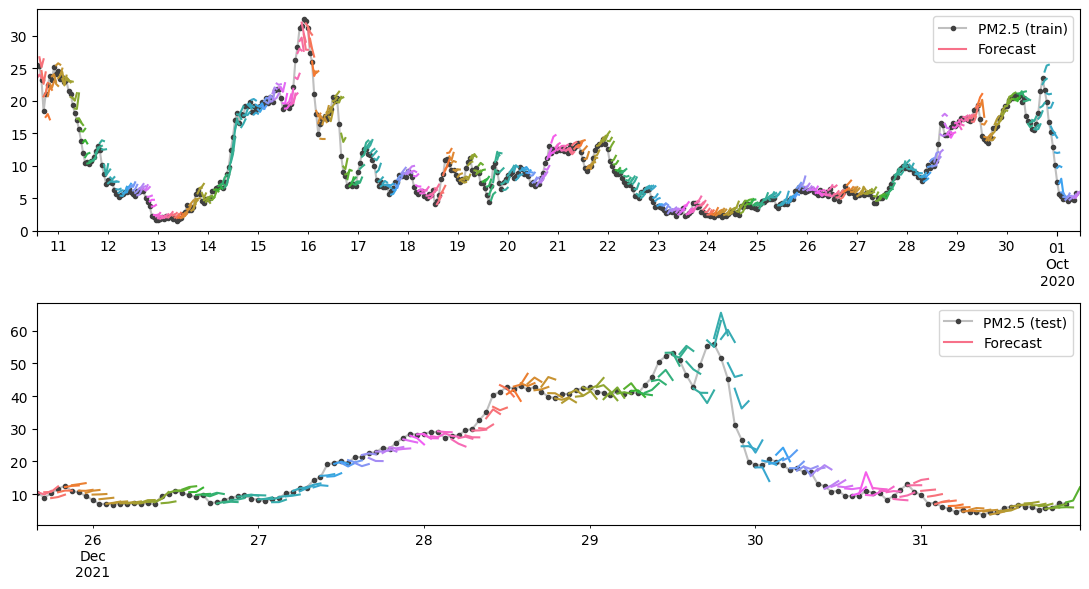

In [99]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = y_data['PM2.5'][y_fit.index[-500:]].plot(color="0.75", style=".-", markeredgecolor="0.25",
    markerfacecolor="0.25", ax=ax1)
ax1 = plot_multistep(y_fit[-500:], ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['PM2.5 (train)', 'Forecast'])
ax2 = y_data['PM2.5'][y_pred.index[-150:]].plot(color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25", ax=ax2)
ax2 = plot_multistep(y_pred[-150:], ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['PM2.5 (test)', 'Forecast'])

This is the last model I have considered. I thought the MultiOutputRegressor may be appropriate here as we are dealing with a continuous variable and, therefore, might benefit from being able to predict multiple outcome simultaneously. 

While the training error of the model was significantly smaller that the previous model, the testing error has slightly increased. As both the train and test error were fairly low in the previous model and suggested better generalisability, I think the previous model was the best of the ones I have made.

In [100]:
model = RegressorChain(XGBRegressor())
model.fit(X_train, y_train)

y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

Train RMSE: 2.89
Test RMSE: 4.75


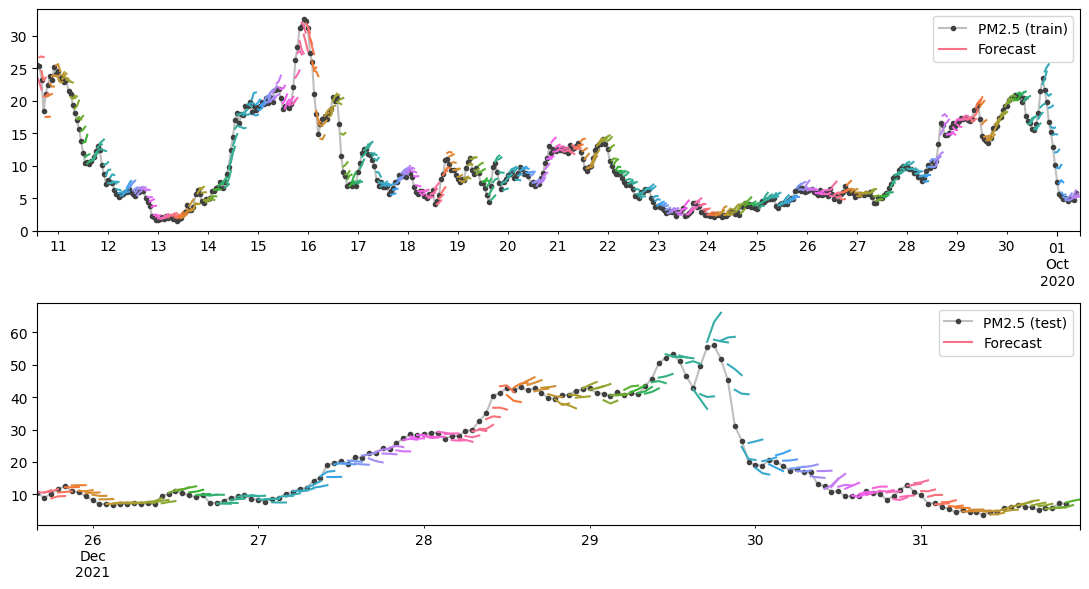

In [101]:
train_rmse = mean_squared_error(y_train, y_fit, squared=False)
test_rmse = mean_squared_error(y_test, y_pred, squared=False)
print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}"))

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = y_data['PM2.5'][y_fit.index[-500:]].plot(color="0.75", style=".-", markeredgecolor="0.25",
    markerfacecolor="0.25", ax=ax1)
ax1 = plot_multistep(y_fit[-500:], ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['PM2.5 (train)', 'Forecast'])
ax2 = y_data['PM2.5'][y_pred.index[-150:]].plot(color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25", ax=ax2)
ax2 = plot_multistep(y_pred[-150:], ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['PM2.5 (test)', 'Forecast'])

The errors of the RegressorChain are very similar to the previous algorithm. It seems that the data is not complex enough for us to need regression to accurately capture serial dependance, and doing this exposes us to propagating errors. Therefore, this is the least favoured model.

# Experimental analysis (performance & scalability) (20%)

Since the third model offered the best performance, I will explore its hyperparameters in this section. I have noted above how adjusting the forecasting period might be helpful for some use cases so I will try to explore how suitable the model would be for longer forecasting periods.

I will mostly focus on adjusting the forecast and lag length as I have already explored various models and periods in the previous section.

In [102]:
def make_and_train_linreg(lag, forecast):
    y = data_ml.copy().set_index('Date and time').drop(columns=['Mod date', 'Date', 'Hour'])
    y_data = data_ml.copy().set_index('Date and time').drop(columns=['Mod date', 'Date', 'Hour'])

    # set lag
    y = y['PM2.5']
    X = make_lags(y, lags=lag).fillna(0.0)

    # set forecast
    y = make_multistep_target(y, steps=forecast).dropna()

    y, X = y.align(X, join='inner', axis=0)

    y.index = [x-1 if x%10!=0 else x+9-10 for x in pd.to_numeric(y.index)]
    X.index = [x-1 if x%10!=0 else x+9-10 for x in pd.to_numeric(X.index)]
    y.index = pd.to_datetime(y.index, format='%Y%m%d%H').to_period('H')
    X.index = pd.to_datetime(X.index, format='%Y%m%d%H').to_period('H')
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, shuffle=False)

    model = LinearRegression()
    model.fit(X_train, y_train)

    y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
    y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

    y_data.index = [x-1 if x%10!=0 else x+9-10 for x in pd.to_numeric(y_data.index)]
    y_data.index = pd.to_datetime(y_data.index, format='%Y%m%d%H')
    y_data.index = y_data.index.to_period('H')

    train_rmse = mean_squared_error(y_train, y_fit, squared=False)
    test_rmse = mean_squared_error(y_test, y_pred, squared=False)
    print((f"Lag: {lag:.2f}\n" f"Forecast: {forecast:.2f}"))
    print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}\n"))

In [103]:
lag_forecast_pairs = [[720, 3], [336, 3], [168, 3], [72, 3], [24, 3], [720, 336], [720, 24], [336, 12], [168, 12], [72, 12],
                      [36, 12], [24, 12], [12, 12], [6, 12]]

for pair in lag_forecast_pairs:
    make_and_train_linreg(pair[0], pair[1])

Lag: 720.00
Forecast: 3.00
Train RMSE: 4.19
Test RMSE: 4.35

Lag: 336.00
Forecast: 3.00
Train RMSE: 4.23
Test RMSE: 4.34

Lag: 168.00
Forecast: 3.00
Train RMSE: 4.26
Test RMSE: 4.34

Lag: 72.00
Forecast: 3.00
Train RMSE: 4.28
Test RMSE: 4.34

Lag: 24.00
Forecast: 3.00
Train RMSE: 4.30
Test RMSE: 4.35

Lag: 720.00
Forecast: 336.00
Train RMSE: 15.05
Test RMSE: 15.73

Lag: 720.00
Forecast: 24.00
Train RMSE: 10.44
Test RMSE: 11.10

Lag: 336.00
Forecast: 12.00
Train RMSE: 8.27
Test RMSE: 8.51

Lag: 168.00
Forecast: 12.00
Train RMSE: 8.32
Test RMSE: 8.53

Lag: 72.00
Forecast: 12.00
Train RMSE: 8.36
Test RMSE: 8.54

Lag: 36.00
Forecast: 12.00
Train RMSE: 8.38
Test RMSE: 8.56

Lag: 24.00
Forecast: 12.00
Train RMSE: 8.39
Test RMSE: 8.56

Lag: 12.00
Forecast: 12.00
Train RMSE: 8.41
Test RMSE: 8.57

Lag: 6.00
Forecast: 12.00
Train RMSE: 8.42
Test RMSE: 8.55



We can see that for the linear regression model, the number of lagged periods does not have a big impact after some point. The error is much more strongly correlated with the forecast period. If the 3 hour forecast was not long enough for a certain person, the next best model to use seems to be the one with lag period of 24 hours and forecast period of 12 hours. Interestingly, the performance did not decrease as significantly as I expected when the lag period became shorter than the forecast period. While not being the best, it is an interesting point to note

Here is a visual representation of the best 12-hour model:

Lag: 24.00
Forecast: 12.00
Train RMSE: 8.39
Test RMSE: 8.56



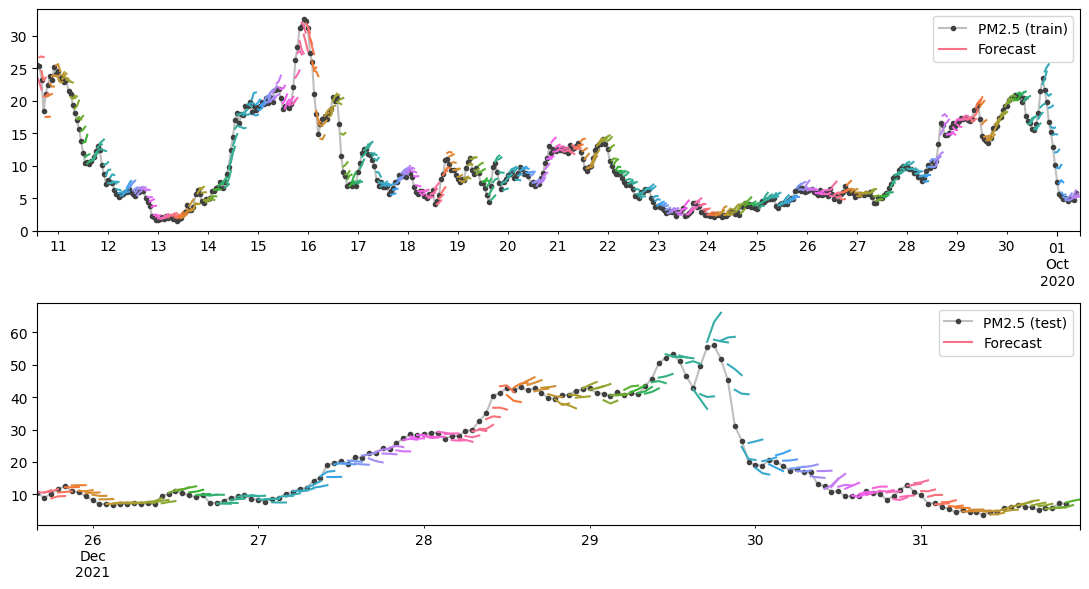

In [104]:
make_and_train_linreg(24, 12)

palette = dict(palette='husl', n_colors=64)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 6))
ax1 = y_data['PM2.5'][y_fit.index[-500:]].plot(color="0.75", style=".-", markeredgecolor="0.25",
    markerfacecolor="0.25", ax=ax1)
ax1 = plot_multistep(y_fit[-500:], ax=ax1, palette_kwargs=palette)
_ = ax1.legend(['PM2.5 (train)', 'Forecast'])
ax2 = y_data['PM2.5'][y_pred.index[-150:]].plot(color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25", ax=ax2)
ax2 = plot_multistep(y_pred[-150:], ax=ax2, palette_kwargs=palette)
_ = ax2.legend(['PM2.5 (test)', 'Forecast'])

I would also like to check whether I could improve the multi-output model, which could allow me to predict longer periods of time if successful. 

In [105]:
def make_and_train_multi(alpha, rlambda):
    model = MultiOutputRegressor(XGBRegressor(reg_alpha=alpha, reg_lambda=rlambda))
    model.fit(X_train, y_train)

    y_fit = pd.DataFrame(model.predict(X_train), index=X_train.index, columns=y.columns)
    y_pred = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)

    train_rmse = mean_squared_error(y_train, y_fit, squared=False)
    test_rmse = mean_squared_error(y_test, y_pred, squared=False)
    print((f"L1 reg term: {alpha:.4f}\n" f"L2 reg term: {rlambda:.4f}"))
    print((f"Train RMSE: {train_rmse:.2f}\n" f"Test RMSE: {test_rmse:.2f}\n"))

In [106]:
regs = [0.0001, 0.001, 0.01, 0.1]

for reg in regs:
    for reg2 in regs:
        make_and_train_multi(reg,reg2)

L1 reg term: 0.0001
L2 reg term: 0.0001
Train RMSE: 2.67
Test RMSE: 4.84

L1 reg term: 0.0001
L2 reg term: 0.0010
Train RMSE: 2.68
Test RMSE: 4.84

L1 reg term: 0.0001
L2 reg term: 0.0100
Train RMSE: 2.68
Test RMSE: 4.85

L1 reg term: 0.0001
L2 reg term: 0.1000
Train RMSE: 2.65
Test RMSE: 4.80

L1 reg term: 0.0010
L2 reg term: 0.0001
Train RMSE: 2.67
Test RMSE: 4.84

L1 reg term: 0.0010
L2 reg term: 0.0010
Train RMSE: 2.68
Test RMSE: 4.82

L1 reg term: 0.0010
L2 reg term: 0.0100
Train RMSE: 2.69
Test RMSE: 4.84

L1 reg term: 0.0010
L2 reg term: 0.1000
Train RMSE: 2.66
Test RMSE: 4.82

L1 reg term: 0.0100
L2 reg term: 0.0001
Train RMSE: 2.68
Test RMSE: 4.84

L1 reg term: 0.0100
L2 reg term: 0.0010
Train RMSE: 2.70
Test RMSE: 4.84

L1 reg term: 0.0100
L2 reg term: 0.0100
Train RMSE: 2.68
Test RMSE: 4.85

L1 reg term: 0.0100
L2 reg term: 0.1000
Train RMSE: 2.68
Test RMSE: 4.79

L1 reg term: 0.1000
L2 reg term: 0.0001
Train RMSE: 2.67
Test RMSE: 4.79

L1 reg term: 0.1000
L2 reg term: 0.001

No matter the combination of regularisation parameters, the errors in the model are not changing. The model is still overfitting on the training set. As such, the linear regression model remains to be the best.

That is positive as linear regression is not very computationally intensive. Even with a larger amount of data, it would be possible to put a model like this into practical use, since it is reasonably fast and accurate. There is also extensive historical data - I have only used the past 5 years for this model but the data available on the Seoul government website dates back to 1988. It would not be difficult to include that data in the model, likely improving its accuraccy.

I have explored and compared my best performing model with other models in the previous section so I do not believe it is necessary for me to go over it in detail again here - please scroll up for the evaluation of this part of the section.

Considering possible future work, there are more things that could be done to improve the model that are out of scope of the assignment as they would require work with various other data sources. Including other environmental data as a feature, for example, could increase the complexity and accuracy of the model. For example, humidity likely has an effect on the concentration of pollutants in the air, so including it in the model could improve its predictive power.

Another possible extension would be working with location data, which was ommited in this notebook. I have only decided to focus on time series data and seasonality in my predictions. However, as all the data is accurately labeled with the location in which it was collected, it would not be complicated to make the predictions more targeted, predicting levels of PM2.5 in various areas of Seoul rather than in the city in general.

Lastly, extending the model to other countries and regions could also be helpful. As pollutants can travel accross long distances, the situation in one place is directly correlated with the situation in another place. Making a larger model that includes pollution levels accross geographical locations could further improve accuracy.

# Ethical considerations (15%)

The most apparent limitation of the model and the dataset itself is its bias towards a specific region, as the data is collected only in Seoul. Only a subset of the population severely affected by air pollution lives in that area, so all of the people who live in other regions are excluded from the potential benefits of air pollution prediction. Additionally, the people who live in Seoul are mostly affluent, while less wealthy individuals usually live outside of the city even if they commute to Seoul. As such, providing an algorithm that is usable only in the wealthiest part of the country disadvantages people based on their economic situation. Such bias could be easily tackled by including measurements from station from around the country; since such stations are already running and such measurements are readily available, it would be an easy form of bias mitigation. It has to be noted that if that was implemented, the area would become much larger, creating the need for changes in the model. The model would have to be adjusted to predict for specific geographic areas rather than the average of all the measurements, and its performance might improve by including measurements from other areas as features.

Another data-driven bias that appears in the model is created by the specific choice of data. In the beginning, I excluded a range of data based on dependency in order to create a model that can accurately predict PM2.5, the most harmful type of pollution. However, low levels of PM2.5 do no necessarily mean low levels of other pollutants which can still be harmful to individuals. If an individual is not properly informed of this, the model could misrepresent reality, making them mistakingly believe they can avoid pollution at a specific time even if pollutants other than PM2.5 are present in high concentrations.

Lastly, there is a lot of interventions the Korean government can consider to bring down the levels of air pollution accross the country. If people have a tool that effectively help them navigate the situation and avoid the worst effect of air pollution, it might make them more complacent and less likely to put pressure on their political representatives to address the issue. Air pollution is an ongoing problem in Korea and accross the world that disproportionately affects poor and marginalised communities who are more likely to live and work close to roads, factories and other sources of harmful pollution. Without a political pressure from them, the problem might be overlooked by the mostly affluent politicians in favour of other problems that are more pressing for the rich.

# Sustainable development relevance & impact (15%)

Air pollution is one of the most pressing issues of the modern world, impacting many different SDGs, some of which I have outlined above. It is imperative that we get pollution under control, not only to improve individual health outcomes but also clean the environment, protect biodiversity and prevent further global warming. In my model, I have focused on the benefits this data and application can have for individuals. However, as I shortly noted above, it can also be used to drive policy decisions to have a wider impact on the world. 

I have outlined how the data and related ML models can improve individual health outcomes and education (SDG3 and SDG4) above. Therefore, I will not repeat it here but rather focus on the wider potential this dataset and its applications have.

Policy-makers could use air pollution prediction to drive policy decisions and decrease air pollution accross the board. For example, they could use predictions of different pollutants to make decisions on when certain high-polluting productions can be ran, allowing them to run only at times when other sources of pollution are relatively low. That could be helpful in improving individuals health and the well-being of their citizens as moderate levels of air polution in the long term are less harmful than shorter spikes of very high levels of pollution. 

This information could also help set realistic targets and expectations. By extending on autoregressive ML models, it could be possible to simulate impacts of different policy decisions on air pollution in the long term. As such, policy makers could make more informed decisions, creating a more effective and trusted government bodies.

Policy makers could also use the data to more effectively target interventions. By incorporating geographic and demograpic data, it would be possible to identify where air pollution has the worst negative impact and which demographic groups are most adversely impacted, making it possible to more effectively aid them.

Lastly, these predictions could be used for evaluations of existing policies. By identifying the trend and its likely future development, policy makers would be able to see how effective the different interventions they actually put into practice are on a much shorter time frame than if they actually had to wait for those outcomes to take place. Again, that could drive a much more effective and efficient policy decision making process, making reduction in air pollution easier and less costly.